In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sympy
from sympy import isprime, primerange
from tqdm import tqdm
from copy import copy
from matplotlib import collections  as mc


%matplotlib inline

## Prepare input

In [2]:
cities = pd.read_csv('../input/cities.csv', index_col=['CityId'])

In [3]:
class Tour(list):  # list with trailing 0
    penalized = ~cities.index.isin(sympy.primerange(0, len(cities)))

    @staticmethod
    def from_file(filename):  # from linkern's output or csv
        seq = [int(x) for x in open(filename).read().split()[1:]]
        return Tour(seq if seq[-1] == 0 else (seq + [0]))

    def score(self):
        df = cities.reindex(self)
        dist = np.hypot(df.X.diff(-1), df.Y.diff(-1))
        penalty = 0.1 * dist[9::10] * self.penalized[self[9::10]]
        _score = dist.sum() + penalty.sum()
        _score = np.round(_score,2)

        return _score

    def to_csv(self, filename):
        pd.DataFrame({'Path': self}).to_csv(filename, index=False)

In [226]:
tour = Tour.from_file('../../../Downloads/LKH-2.0.9/data/linkern.tour')
#tour.to_csv('pool/{}.csv'.format(tour.score()))
print(tour.score())

1517113.59


In [231]:
%%timeit
aa = mutate(Individual(tour))

79.7 ms ± 3.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [232]:
yolo = crossover(aa, Individual(tour))

KeyboardInterrupt: 

In [5]:
from math import hypot
class Node:
    """
    represents a node in a TSP tour
    """
    def __init__(self, num, coords):
        self.num = num # start position in a route's order
        self.x = coords[0]   # x coordinate
        self.y = coords[1]   # y coordinate

    def __str__(self):
        """
        returns the string representation of a Node
        """
        return self.num

    def __eq__(self, other):
        return self.__dict__ == other.__dict__

    def euclidean_dist(self, other):
        """
        returns the Euclidean distance between this Node and other Node
        other - other node
        """
        dx = self.x - other.x
        dy = self.y - other.y
        return hypot(dx, dy)

In [6]:
PATH = []
for i in range(len(tour)):
    PATH.append(Node(tour[i], cities.values[tour[i]]))

In [7]:
def sscore(p):
    distance = 0.0
    for i in range(len(p)-1):
        d = p[i].euclidean_dist(p[i+1])
        if i%10 == 0 and not isprime(p[i-1].num): d *= 1.1 
        distance += d
    return distance

In [8]:
sscore(PATH)

1517126.8455356655

197769

# Newly improved GSX (GSX-2).

In [9]:
parent1 = list(range(1,42))
parent1 = np.random.permutation(parent1)
parent1 = np.insert(parent1, 0, 0)
parent1 = np.insert(parent1, len(parent1), 0)
parent1

array([ 0, 33, 20, 39, 15,  7, 21, 12, 31, 32, 17, 34, 36, 13, 14, 35, 30,
       40, 27, 29, 22,  9, 26,  8,  2,  4, 18, 41,  5, 37, 25, 10, 28,  1,
        6,  3, 16, 24, 23, 38, 19, 11,  0])

In [10]:
parent2 = list(range(1,42))
parent2 = np.random.permutation(parent2)
parent2 = np.insert(parent2, 0, 0)
parent2 = np.insert(parent2, len(parent2), 0)
parent2

array([ 0, 11, 36,  3, 15, 18,  8, 29, 26, 16, 39, 19, 24, 25,  5, 10,  1,
       41, 21, 35, 12, 33, 30, 13,  4, 27,  2,  9,  7, 40, 14, 38,  6, 17,
       31, 34, 37, 32, 22, 28, 20, 23,  0])

### Step 1 : select random city 

In [11]:
rnd_city = np.random.randint(low=1, high=43)
rnd_city

5

### Step 2: alternately add cities from parents, each for one direction, until either a city that has already been included in the offspring is met or exchangeable subtours are found

In [12]:


offspring = [rnd_city]
rnd_city_in_parent1 = np.argwhere(parent1 == rnd_city)[0][0]
rnd_city_in_parent2 = np.argwhere(parent2 == rnd_city)[0][0]
city_included = [rnd_city]
STOP = False
idx1 = rnd_city_in_parent1 + 1
idx2 = rnd_city_in_parent2 - 1
while not STOP:
    if idx1 < len(parent1)-1: ## -1 for the 0 
        if parent1[idx1] in city_included:
            STOP = True
            break
        offspring.append(parent1[idx1])
        city_included.append(parent1[idx1])
        idx1+=1
    else:
        break
 
    if idx2 > 0: ## > strict for the 0
        if parent2[idx2] in city_included:
            STOP = True
            break
        offspring.insert( 0,parent2[idx2])
        city_included.append(parent2[idx2])
        idx2-=1

In [13]:
offspring

[25, 5, 37]

### Step 3: fill in the remaining cities at the order of parent 2

In [14]:
for i in range(1, len(parent2)-1): ##-1 for the zero
    if parent2[i] not in city_included:
        offspring.append(parent2[i])

In [15]:
offspring.append(0)
offspring.insert(0, 0)

In [16]:
print(offspring)

[0, 25, 5, 37, 11, 36, 3, 15, 18, 8, 29, 26, 16, 39, 19, 24, 10, 1, 41, 21, 35, 12, 33, 30, 13, 4, 27, 2, 9, 7, 40, 14, 38, 6, 17, 31, 34, 32, 22, 28, 20, 23, 0]


In [17]:
print( Tour(parent1).score(), Tour(parent2).score(), Tour(offspring).score())

89396.61 94625.9 94974.03


In [18]:
assert len(offspring)==len(parent1)==len(parent2)
assert offspring[0]==offspring[-1]==0
assert len(set(offspring))==len(offspring)-1

 ## Double-bridge move mutation operator

In [19]:
i, ii, j, jj, k, kk, l, ll = 3, 4, 9, 10, 28, 29, 35, 36

In [20]:
new_route = offspring[0:i+1]

new_route.append(offspring[kk])
new_route.extend(offspring[kk+1:l+1])
new_route.append(offspring[jj])
new_route.extend(offspring[jj+1:k+1])
new_route.append(offspring[ii])
new_route.extend(offspring[ii+1:j+1])
new_route.append(offspring[ll])
new_route.extend(offspring[ll+1:])

print(new_route)
print("+++++++++++++")
print(offspring)


assert len(new_route)==len(offspring)
assert new_route[0]==new_route[-1]==0
assert len(set(new_route))==len(new_route)-1
print( Tour(offspring).score(), Tour(new_route).score())




[0, 25, 5, 37, 7, 40, 14, 38, 6, 17, 31, 29, 26, 16, 39, 19, 24, 10, 1, 41, 21, 35, 12, 33, 30, 13, 4, 27, 2, 9, 11, 36, 3, 15, 18, 8, 34, 32, 22, 28, 20, 23, 0]
+++++++++++++
[0, 25, 5, 37, 11, 36, 3, 15, 18, 8, 29, 26, 16, 39, 19, 24, 10, 1, 41, 21, 35, 12, 33, 30, 13, 4, 27, 2, 9, 7, 40, 14, 38, 6, 17, 31, 34, 32, 22, 28, 20, 23, 0]
94974.03 94860.73


In [21]:
for  i in offspring:
    if i not in new_route:
        print (i)

In [22]:
def swap_2opt(route, i, k):
    """
    swaps the endpoints of two edges by reversing a section of nodes, 
    ideally to eliminate crossovers
    returns the new route created with a the 2-opt swap
    route - route to apply 2-opt
    i - start index of the portion of the route to be reversed
    k - index of last node in portion of route to be reversed
    pre: 0 <= i < (len(route) - 1) and i < k < len(route)
    post: length of the new route must match length of the given route 
    """
    assert i >= 0 and i < (len(route) - 1)
    assert k > i and k < len(route)
    new_route = route[0:i]
    new_route.extend(reversed(route[i:k + 1]))
#    reversed(route[i:k + 1])
    new_route.extend(route[k+1:])
    assert len(new_route)==len(route)
    assert new_route[0]==new_route[-1]==0
    assert len(set(new_route))==len(new_route)-1
    return Tour(new_route)

In [43]:
from multiprocessing import Process, Pool
import os
import time

def info(title):
    print(title)
    print('module name:', __name__)
    print('parent process:', os.getppid())
    print('process id:', os.getpid())
    time.sleep(3)

def f(name):
    info('function f')
    print('hello', name)

if __name__ == '__main__':
     with Pool(8) as p:
        print(p.map(info, ))
        
        
        
        
        

NameError: name 'cities_per_thread' is not defined

In [133]:
from multiprocessing import Queue
def task(bucket, route, best_distance, result):
    (start, end) = bucket
    for i in range(start, end):
        for k in range(i+1, len(route)-1):
            new_route = swap_2opt(route, i, k) ## replace by call to Julia
            new_distance = new_route.score()
            if new_distance < best_distance:
                result.put((new_distance, i, k))

In [134]:
qq = Queue()
task((10, 30), Tour(population[0].path), Tour(population[0].path).score(), qq)
    

In [128]:
qq.get()

(72780.0, 29, 33)

In [129]:
qq.empty()

False

In [221]:
def run_2opt(route):
    """
    improves an existing route using the 2-opt swap until no improved route is found
    best path found will differ depending of the start node of the list of nodes
        representing the input tour
    returns the best path found
    route - route to improve
    """
    improvement = True
    best_route = route
    best_distance = route.score()
    
    n_threads = 10
    
    cities_per_thread = []
    if (len(population[0].path)-2)%n_threads:
        cities_per_thread.append((len(population[0].path)-2)%n_threads) 
    for i in range(len(population[0].path)//n_threads):
        cities_per_thread.append(n_threads)

    buckets = [] 
    OPTS = []

    for i, bucket in enumerate(np.cumsum(cities_per_thread)):
        #print(i, bucket)
        if i == 0:
            buckets.append((1, bucket))#    population[0].path[1:-1][:bucket]     )

        else:
            buckets.append((buckets[-1][1], bucket)) #population[0].path[1:-1][np.cumsum(cities_per_thread)[i-1]:bucket]  )

            
   
    while improvement: 
        improvement = False
        
        processes = []
        best_distance = route.score()
        qq = Queue()
        
        for bucket in buckets:
            p = Process(target=task, args=(bucket, route, best_distance, qq))
            processes.append(p)
            p.start()
        for process in processes:
            process.join()

            
        while not qq.empty():
            OPTS.append(qq.get())
        #print("++++")
        #print(len(OPTS))
        #print("++++")
        
        if len(OPTS) > 0:
            improvement = True
            OPTS = sorted(OPTS, key=lambda x: x[0])
            print( OPTS[0] )
            if len(OPTS) > 4:
                chosen_swap = random.choice(OPTS[:4])
            else:
                chosen_swap = OPTS[0]
            route = swap_2opt(route, chosen_swap[1], chosen_swap[2])
            best_distance = route.score()

            OPTS = []
            
            
       
    assert len(best_route)==len(route)
    assert best_route[0]==best_route[-1]==0
    assert len(set(best_route))==len(best_route)-1
    
    return route

In [222]:
_ = run_2opt(Tour(generate_ind().path))

(86180.66, 3, 28)
(79300.51, 3, 12)
(72935.18, 30, 40)
(67803.89, 2, 21)
(62863.46, 18, 39)
(58825.6, 18, 39)
(57308.51, 10, 35)
(54064.11, 37, 39)
(51082.84, 15, 25)
(48610.33, 5, 31)
(46409.3, 5, 18)
(43611.61, 6, 29)
(41218.26, 8, 27)
(38587.68, 12, 32)
(36445.45, 12, 32)
(33980.33, 12, 32)
(33103.43, 13, 22)
(32364.12, 2, 37)
(31127.91, 17, 32)
(29940.34, 2, 37)
(28916.01, 2, 37)
(28363.12, 7, 10)
(27628.39, 2, 37)
(26604.34, 29, 32)
(26053.2, 29, 32)
(25442.36, 29, 32)
(24926.27, 29, 32)
(23969.26, 7, 35)
(23568.68, 7, 35)
(22989.8, 7, 35)
(22666.91, 7, 35)
(22215.97, 14, 18)
(22012.25, 12, 14)
(21855.5, 28, 29)
(21781.76, 30, 31)
(21769.73, 34, 35)
(21768.3, 17, 18)
(21544.28, 16, 17)


In [471]:
route = population[0].path

In [192]:
import random 
random.choice([1,2,3,4,45,5,4][:len([1,2,3,4,45,5,4])])

45

In [218]:
len([1,2,3,4,45,5,4])%3

1

In [223]:
population = []
popSize = 100
nGen = 50
SP = 2.0
mut_rate = .1
for i in range(popSize):
    ind = generate_ind()
    ind.pos = i
    population.append(ind)

In [224]:
population = sorted(population, key=lambda x: x.fitness, reverse=True)
for i in range(len(population)):
    population[i].rank = get_rank(popSize, SP, i)

Gen 0 - Best: 77041.91
(71530.45, 6, 24)
(67119.38, 6, 24)
(62986.54, 9, 18)
(57003.88, 8, 20)
(56535.66, 9, 28)
(53508.28, 13, 16)
(50368.54, 12, 39)
(47776.46, 32, 40)
(45060.54, 26, 35)
(43108.69, 11, 24)
(41356.74, 11, 24)
(39667.45, 4, 28)
(37633.81, 3, 13)
(36084.22, 3, 13)
(34580.57, 27, 37)
(33277.47, 27, 37)
(32076.82, 8, 18)
(30798.08, 7, 36)
(29299.07, 7, 23)
(28388.24, 7, 23)
(27485.11, 7, 23)
(26814.03, 7, 23)
(26173.21, 7, 23)
(24694.12, 22, 30)
(24141.89, 22, 30)
(24507.76, 30, 31)
(24048.3, 27, 28)
(23692.48, 39, 40)
(23372.17, 39, 40)
(22997.36, 39, 40)
(22773.35, 17, 18)
(22606.96, 17, 18)
(22431.95, 17, 18)
(22297.96, 26, 27)
(22230.79, 1, 5)
(21907.91, 1, 4)
21907.91
Gen 1 - Best: 21907.91
(70670.78, 1, 40)
(65350.32, 1, 40)
(61992.48, 33, 41)
(58391.3, 1, 10)
(55217.47, 1, 10)
(52202.3, 1, 19)
(48340.71, 1, 19)
(45096.62, 8, 37)
(42745.52, 5, 34)
(40842.92, 23, 39)
(38746.95, 23, 39)
(37075.95, 19, 21)
(35500.47, 21, 32)
(34022.95, 1, 40)
(32830.79, 16, 22)
(31574.

/Users/yfe/.local/share/virtualenvs/kaggle-traveling-santa-2018-prime-paths-3WV7d9iS/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


(30176.57, 6, 38)
(26240.41, 6, 38)
(23292.72, 6, 38)
(22619.59, 6, 38)
(25317.92, 6, 38)
(25976.6, 6, 10)
(24451.56, 11, 36)
(23308.52, 11, 36)
(22619.59, 11, 36)
(22273.85, 11, 36)
(21972.73, 11, 36)
(22702.71, 22, 30)
(22531.25, 22, 30)
(21918.66, 23, 31)
(21850.91, 12, 36)
(20717.65, 12, 35)
20717.65
Gen 22 - Best: 20546.52
20546.52
Gen 23 - Best: 20546.52
(20977.99, 1, 40)
(20546.52, 2, 41)
20546.52
Gen 24 - Best: 20546.52
20546.52
Gen 25 - Best: 20546.52
(25953.24, 1, 27)
(20560.98, 1, 23)
(20546.52, 1, 41)
20546.52
Gen 26 - Best: 20546.52
(23708.38, 1, 39)
(23006.96, 2, 41)
(20546.52, 6, 41)
20546.52
Gen 27 - Best: 20546.52
20546.52
Gen 28 - Best: 20546.52
(24209.8, 25, 41)
(23251.02, 1, 35)
(21748.0, 1, 35)
(21100.49, 1, 34)
(20560.98, 1, 40)
(20546.52, 1, 41)
20546.52
Gen 29 - Best: 20546.52
(27007.35, 20, 41)
(20560.98, 1, 19)
(20546.52, 1, 41)
20546.52
Gen 30 - Best: 20546.52
(26965.4, 14, 41)
(23359.97, 1, 7)
(22935.22, 1, 7)
(22614.0, 30, 36)
(21695.84, 7, 13)
(23626.23, 1

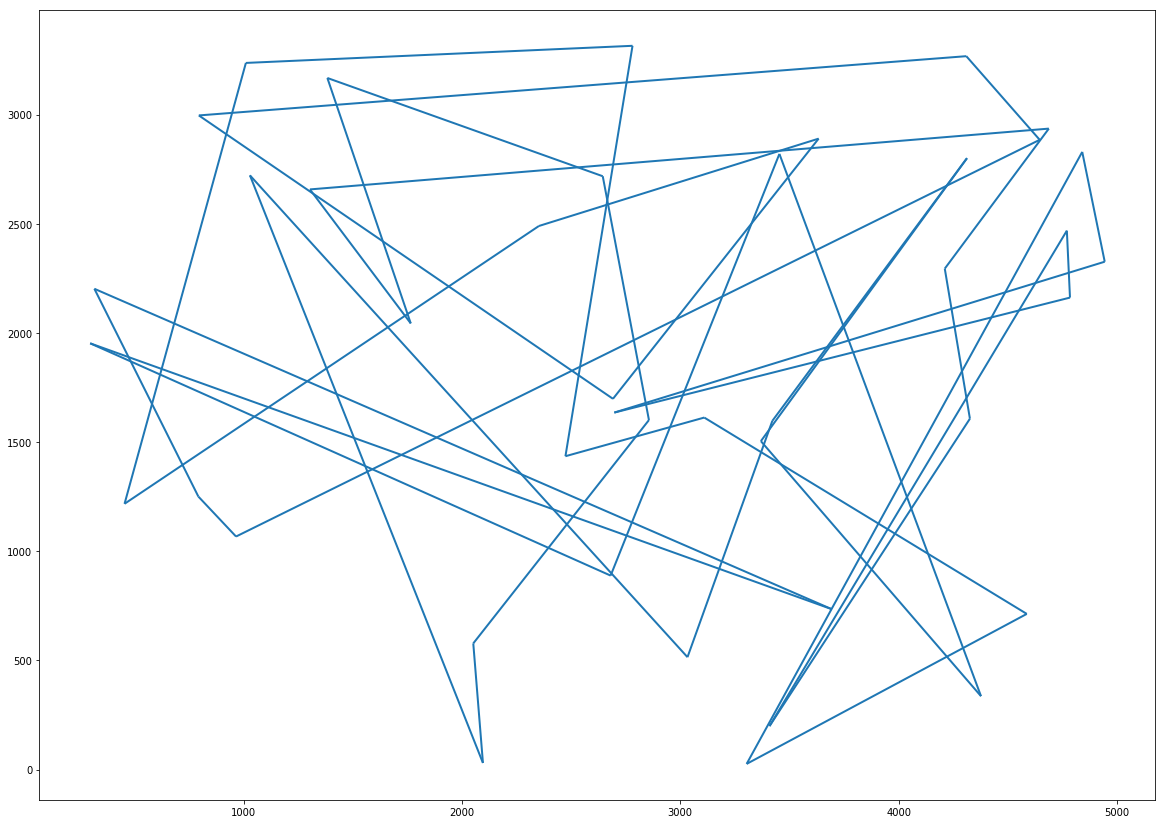

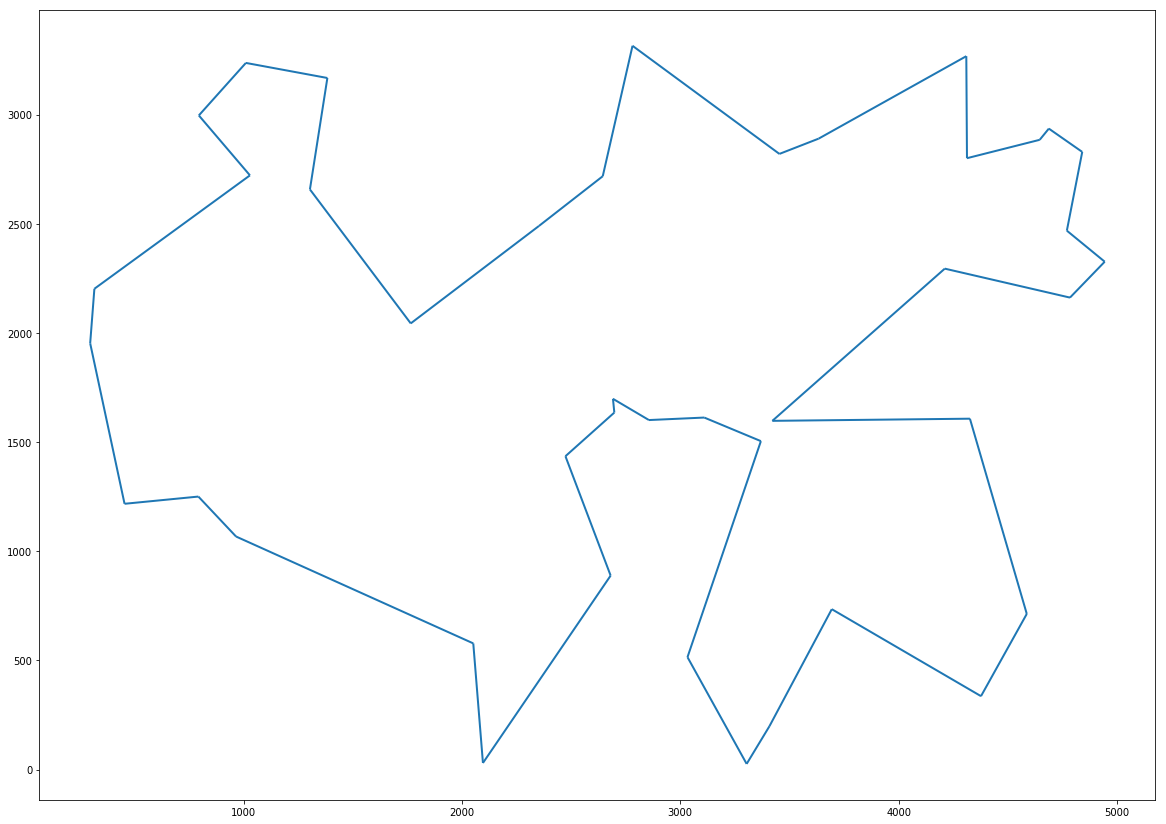

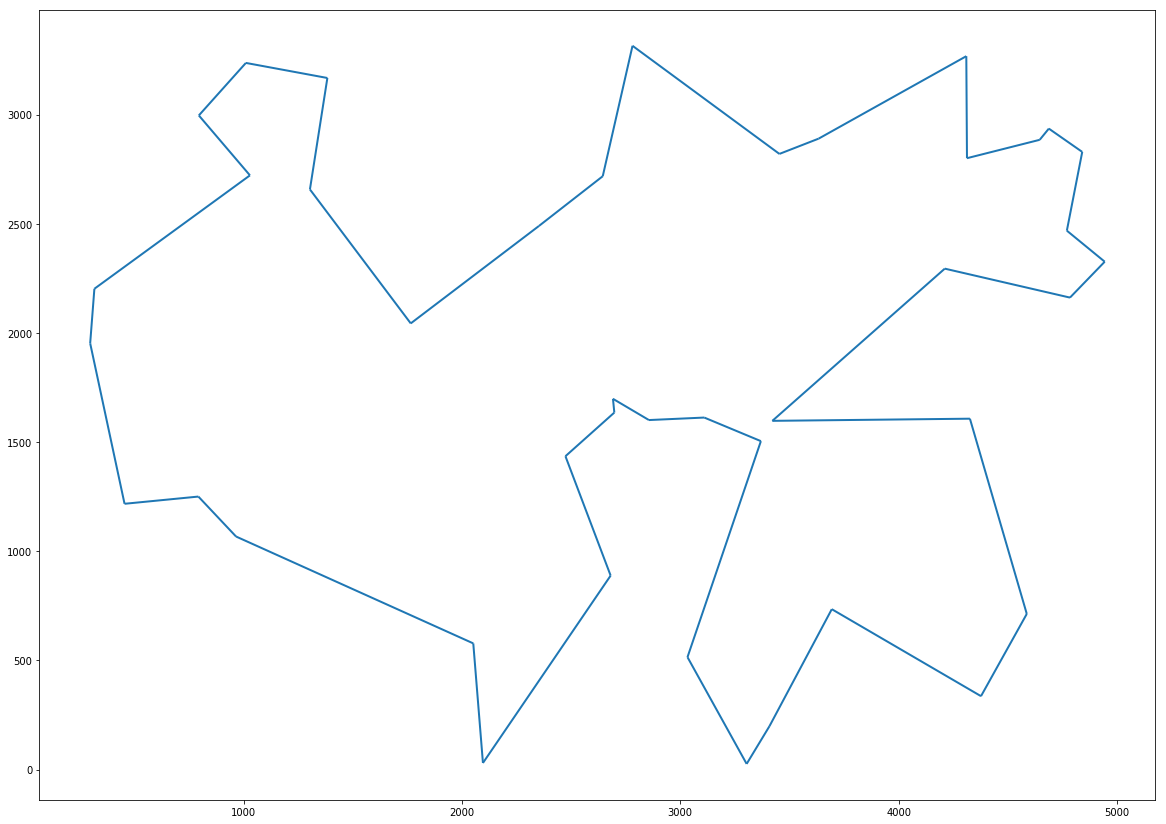

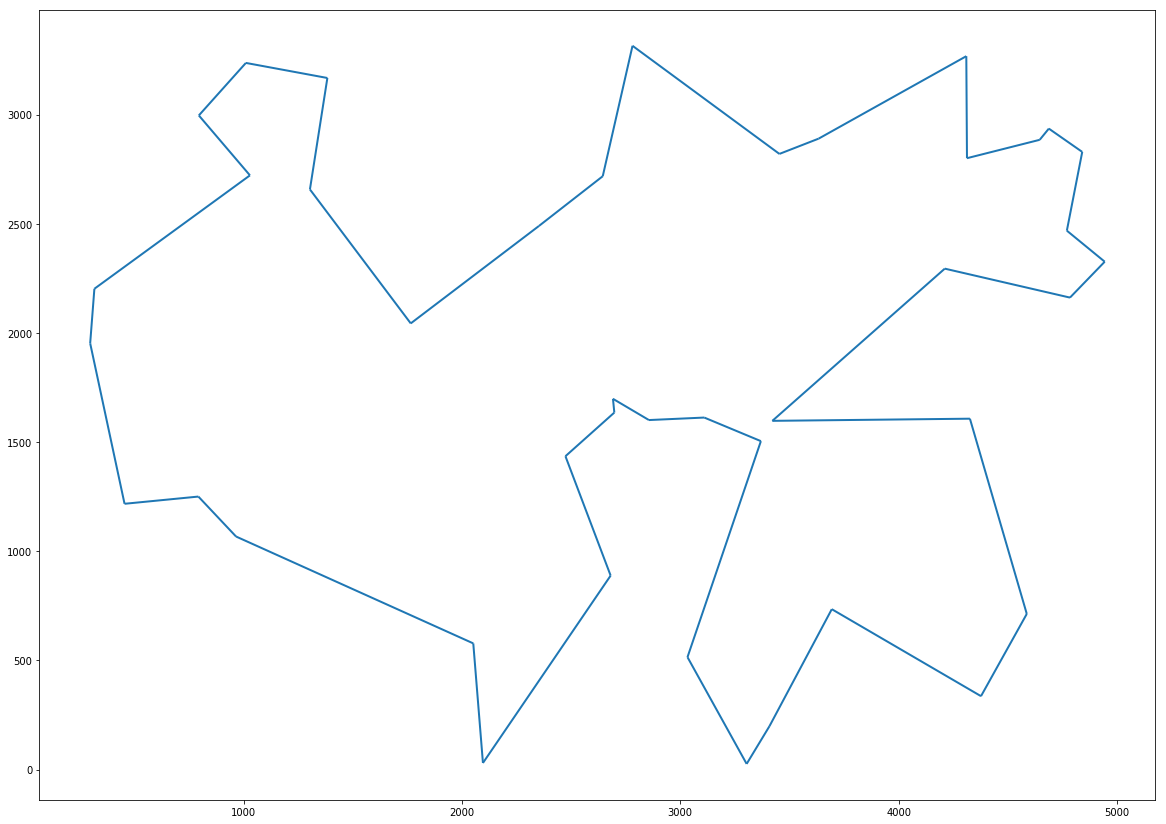

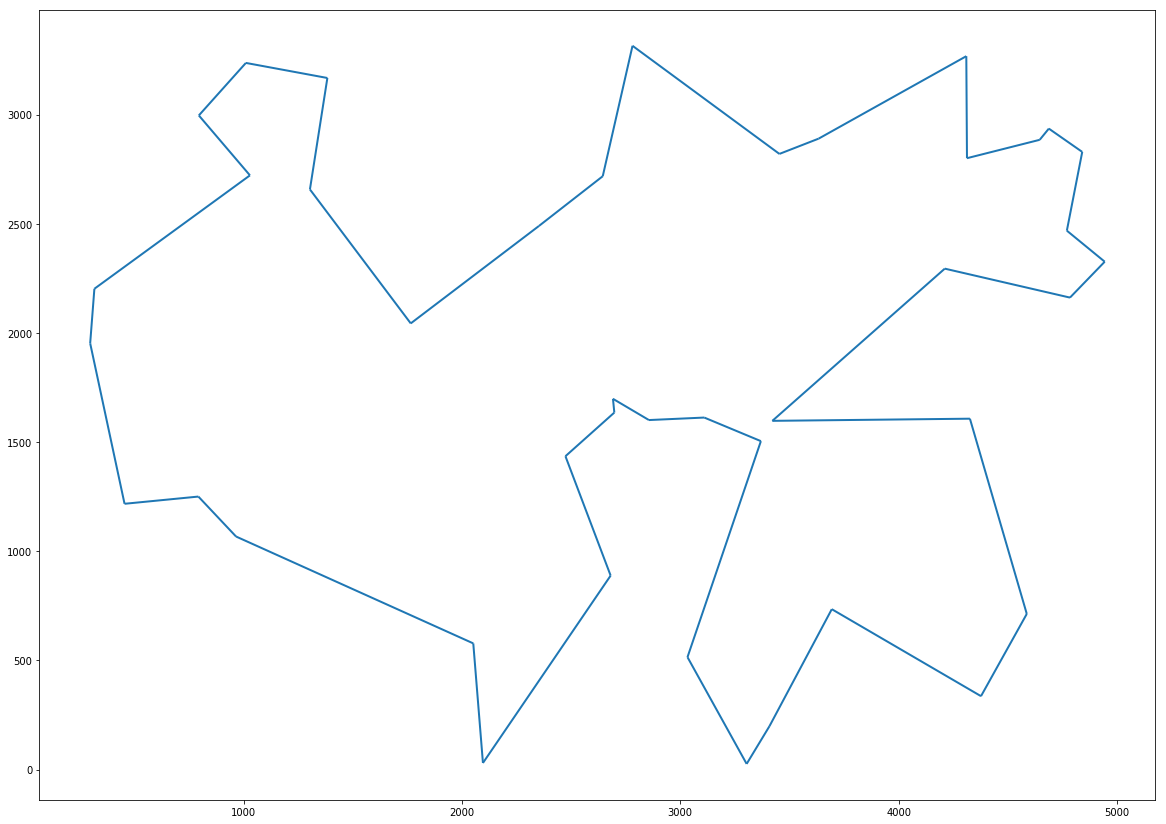

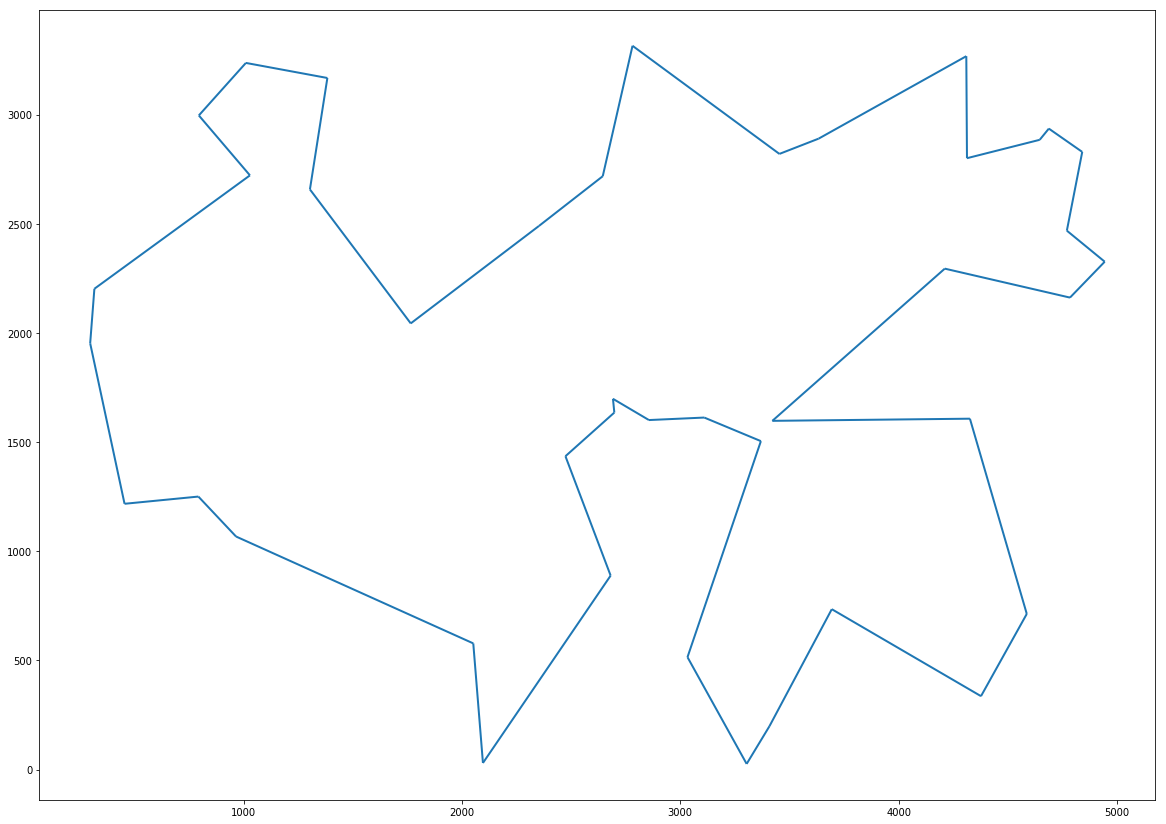

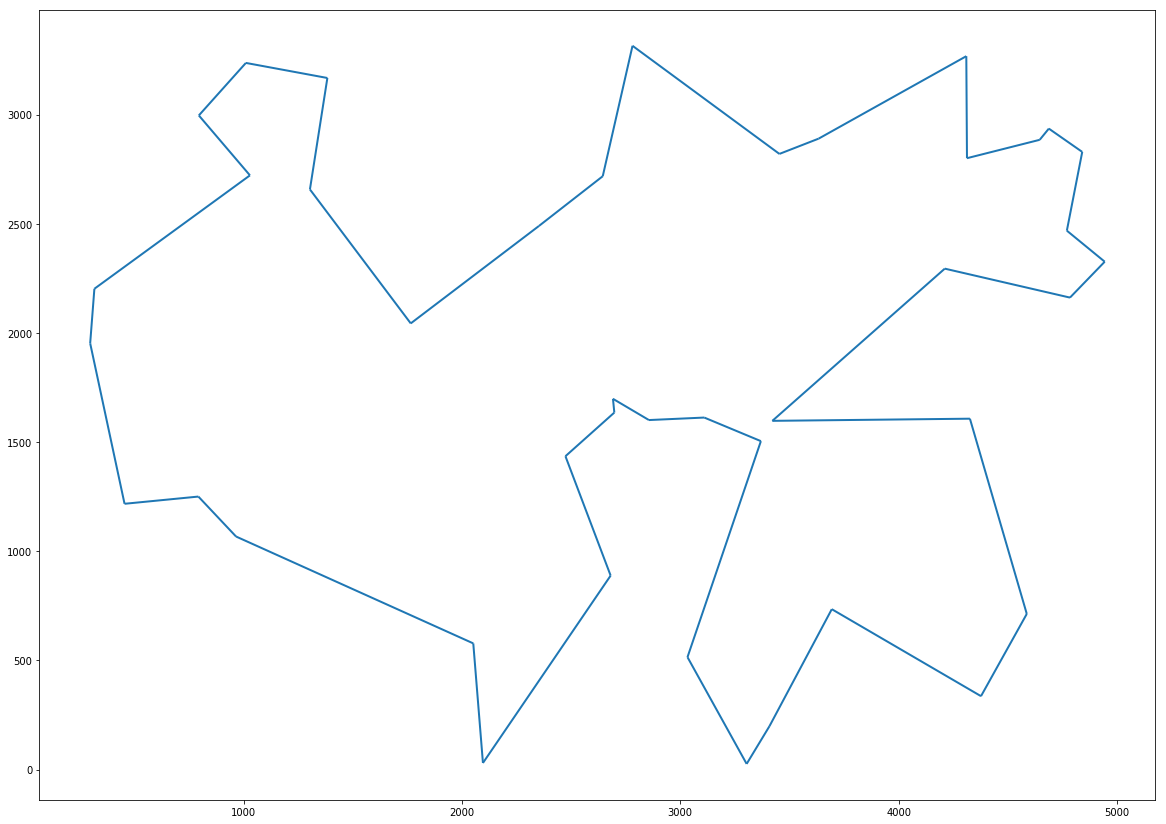

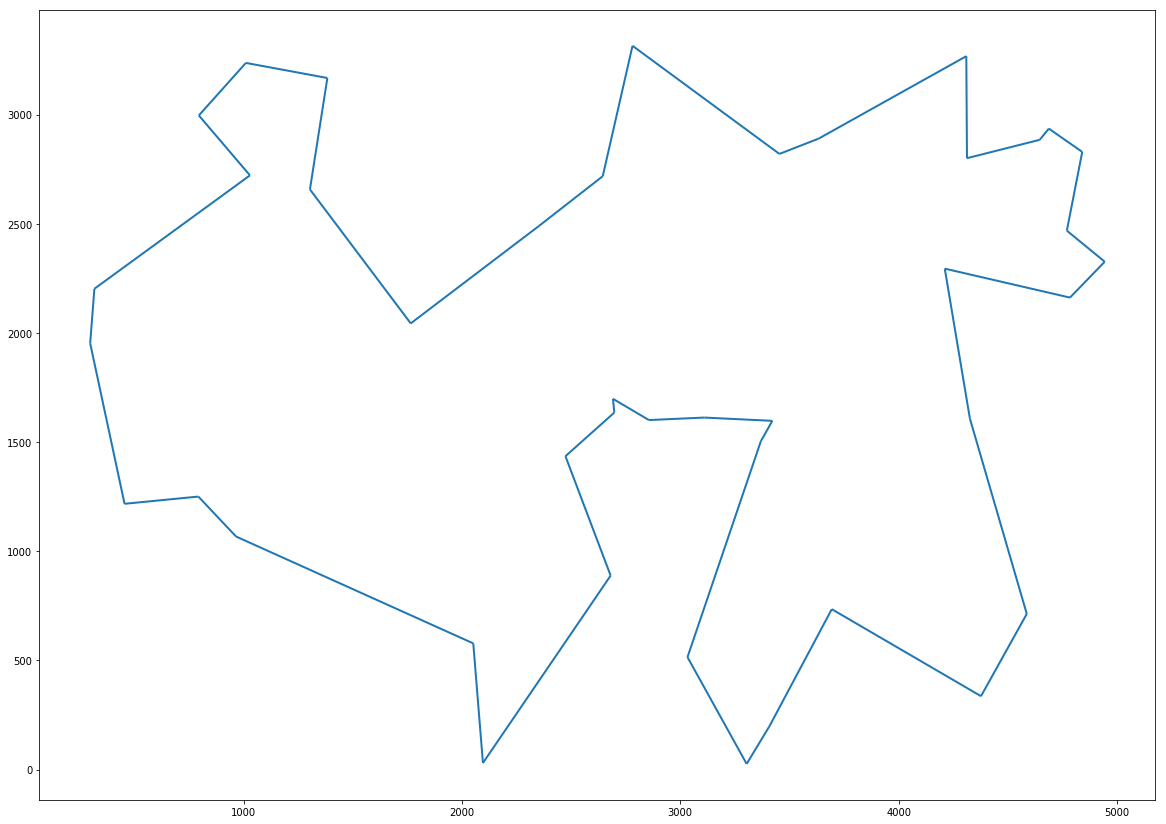

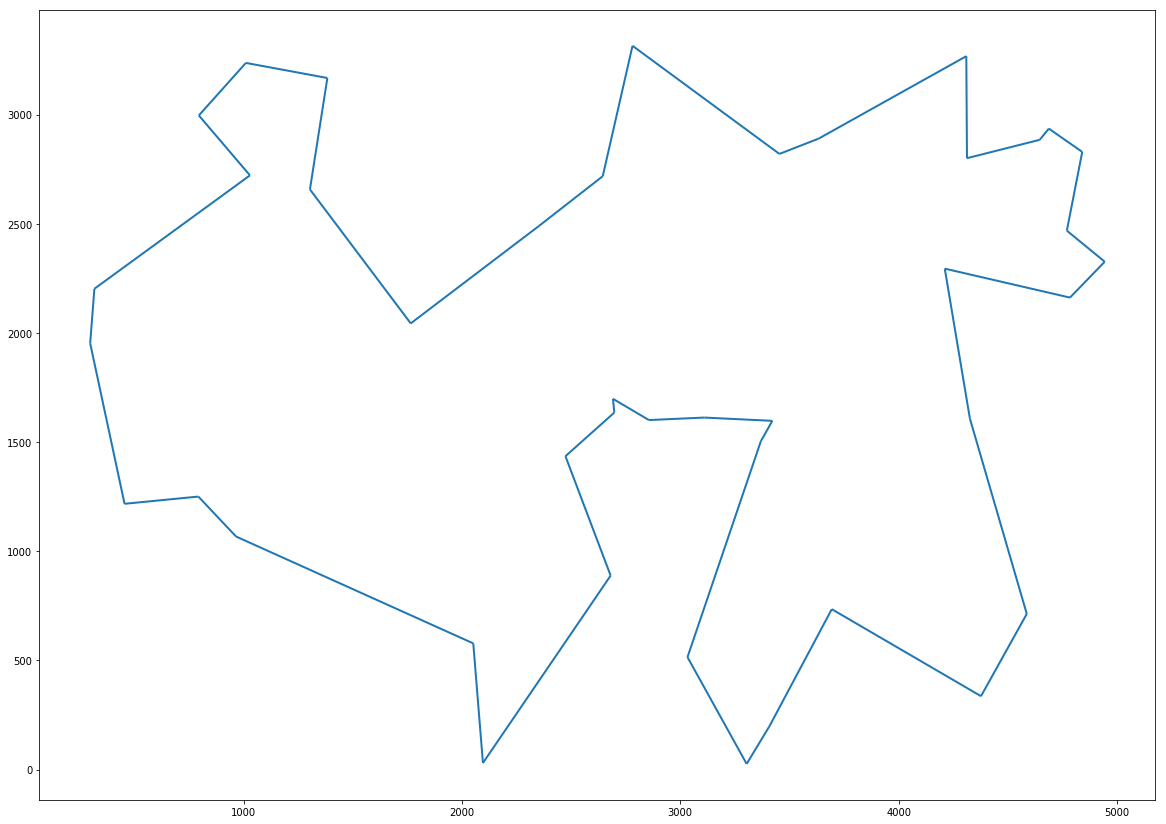

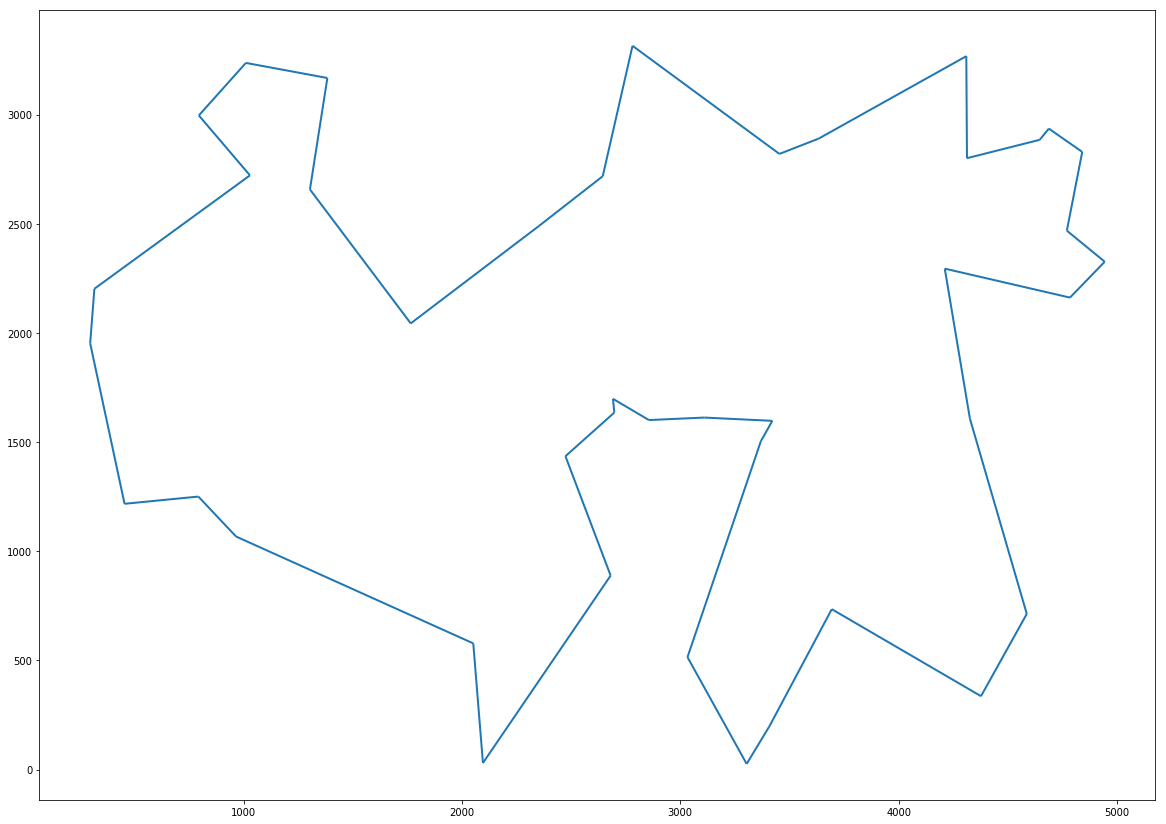

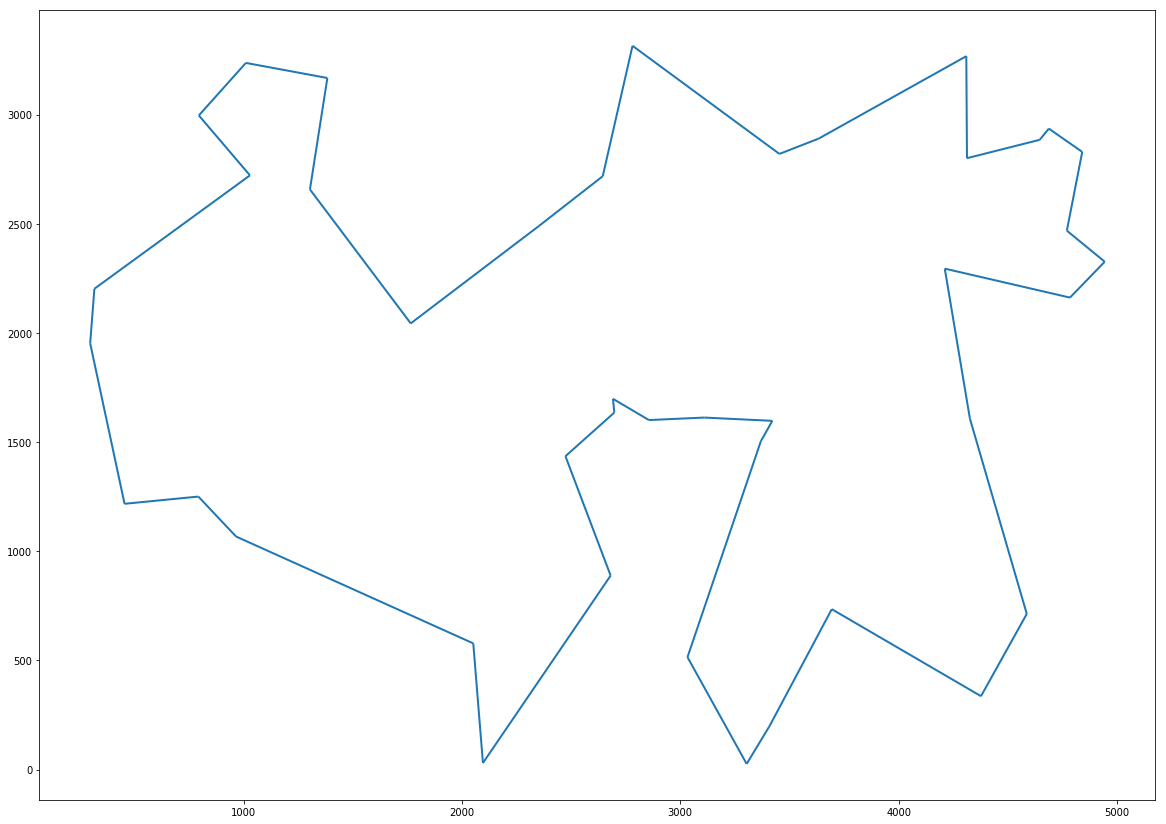

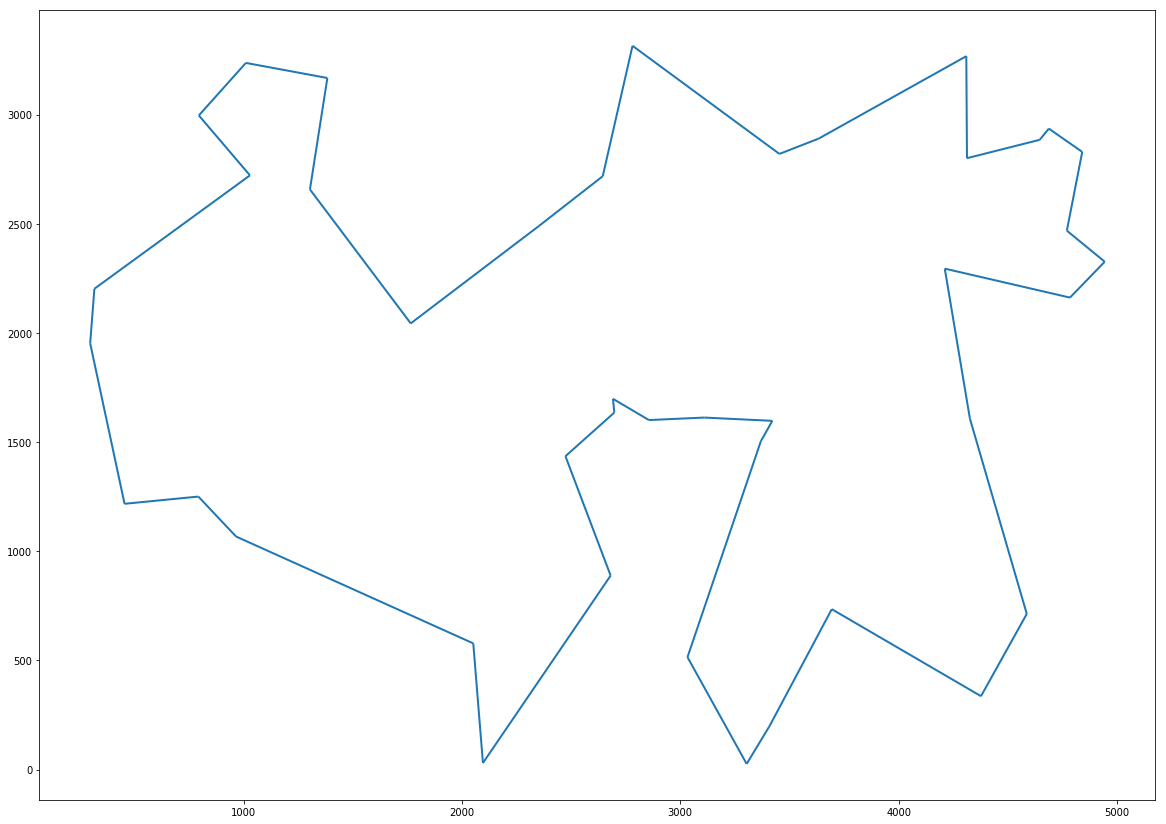

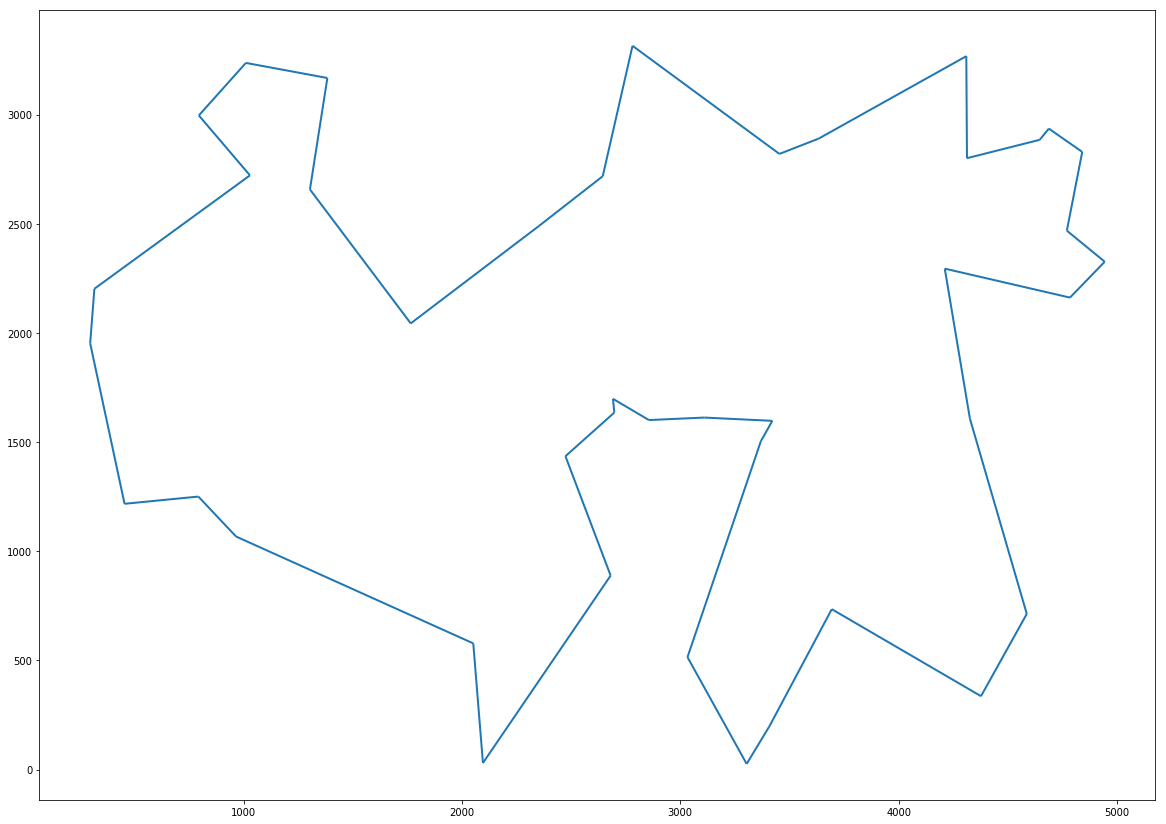

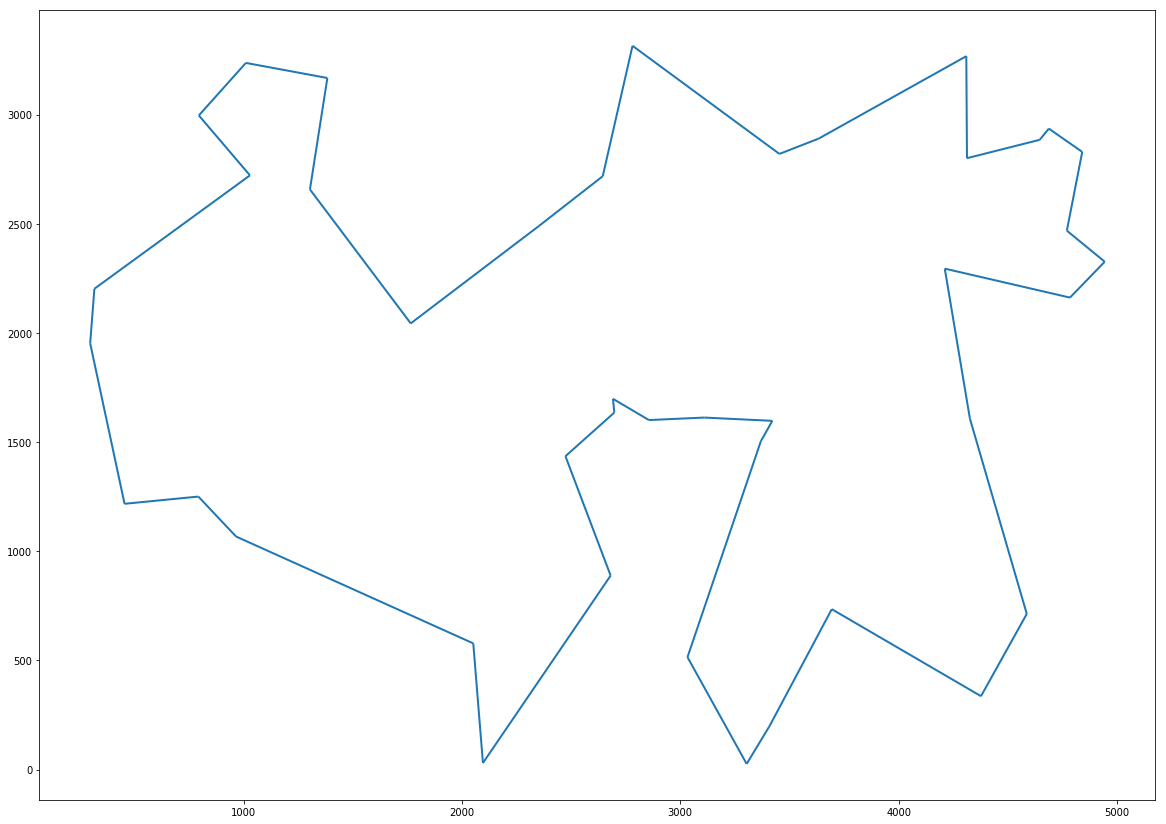

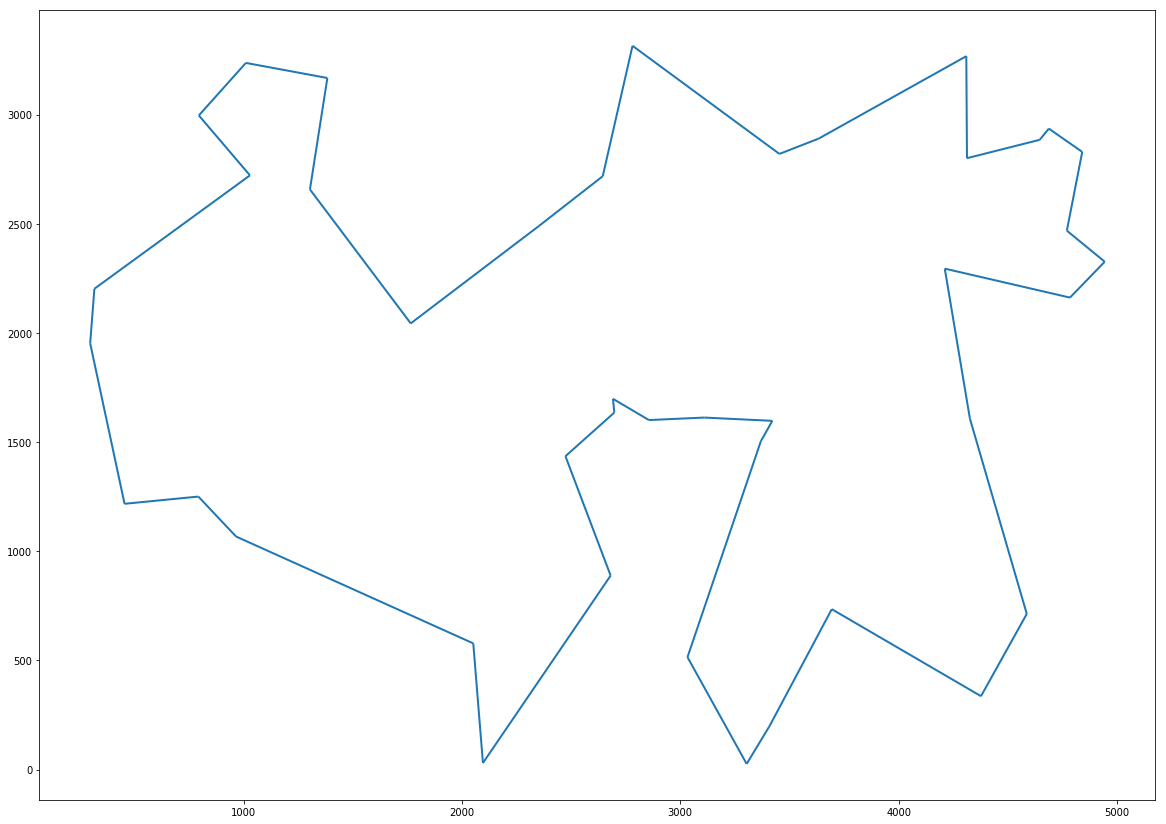

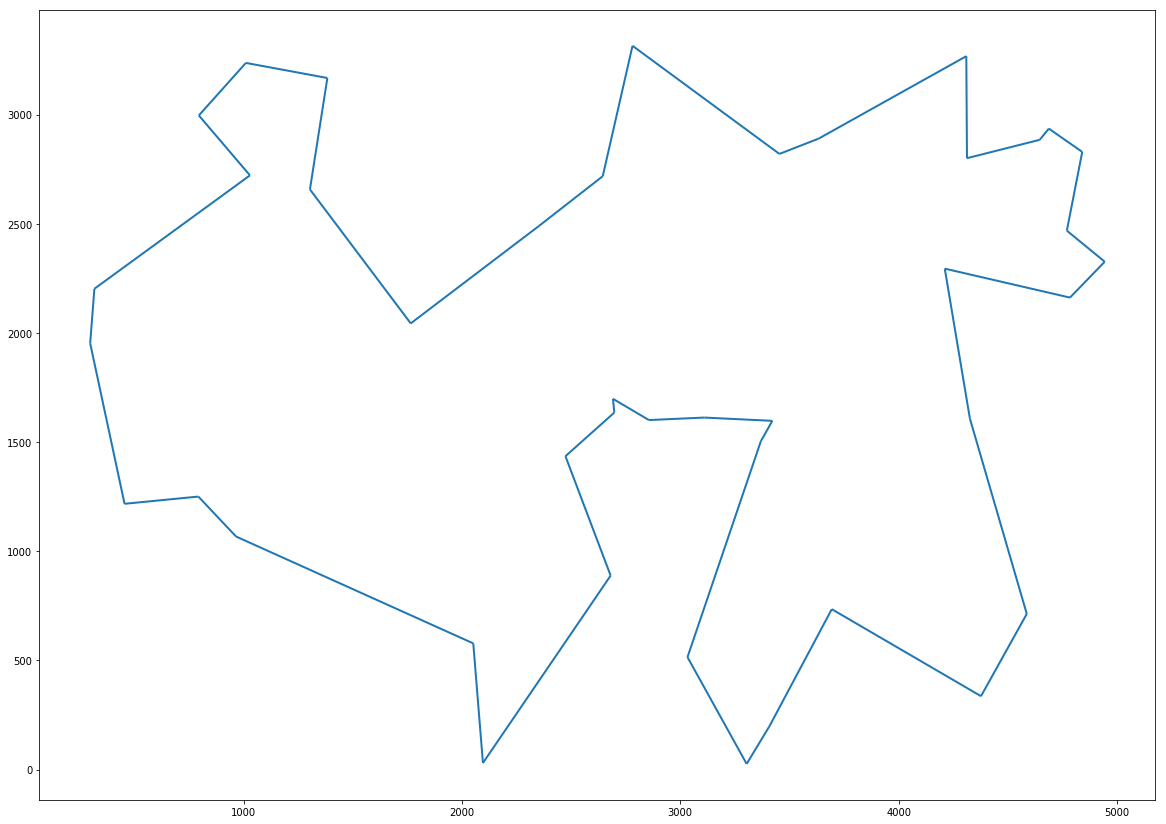

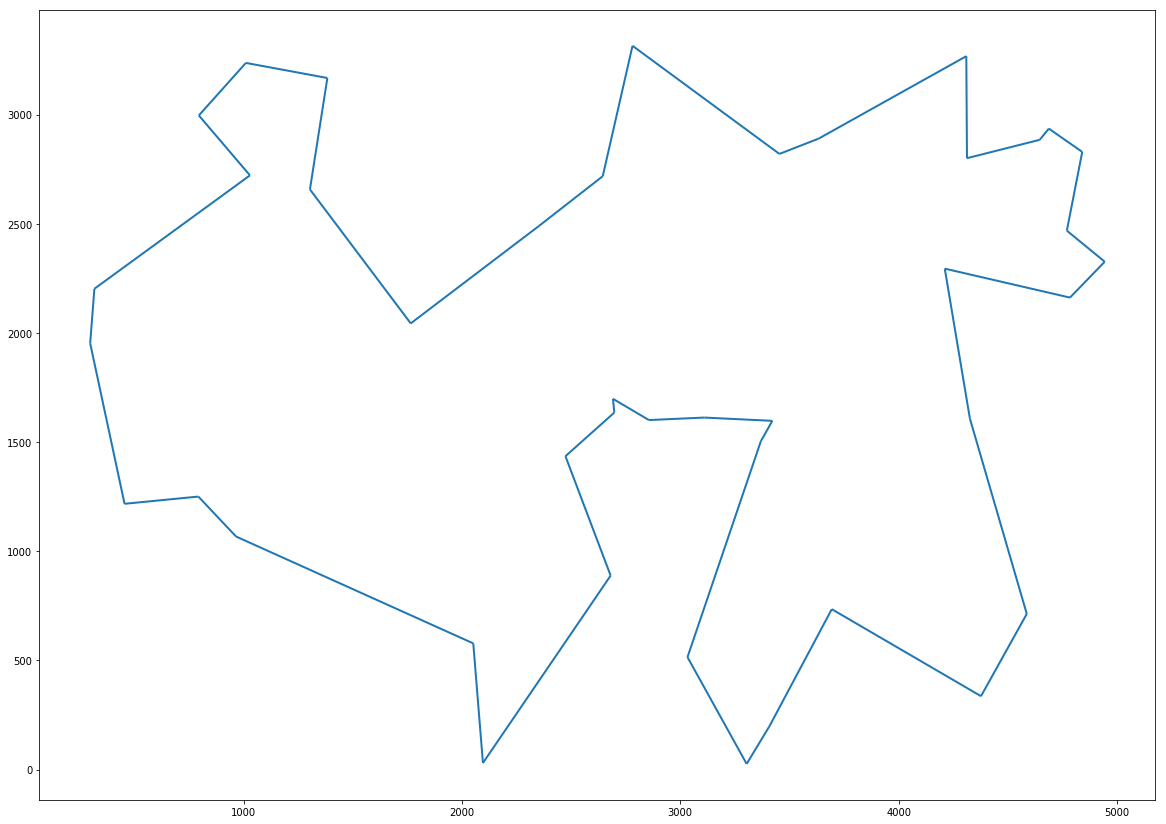

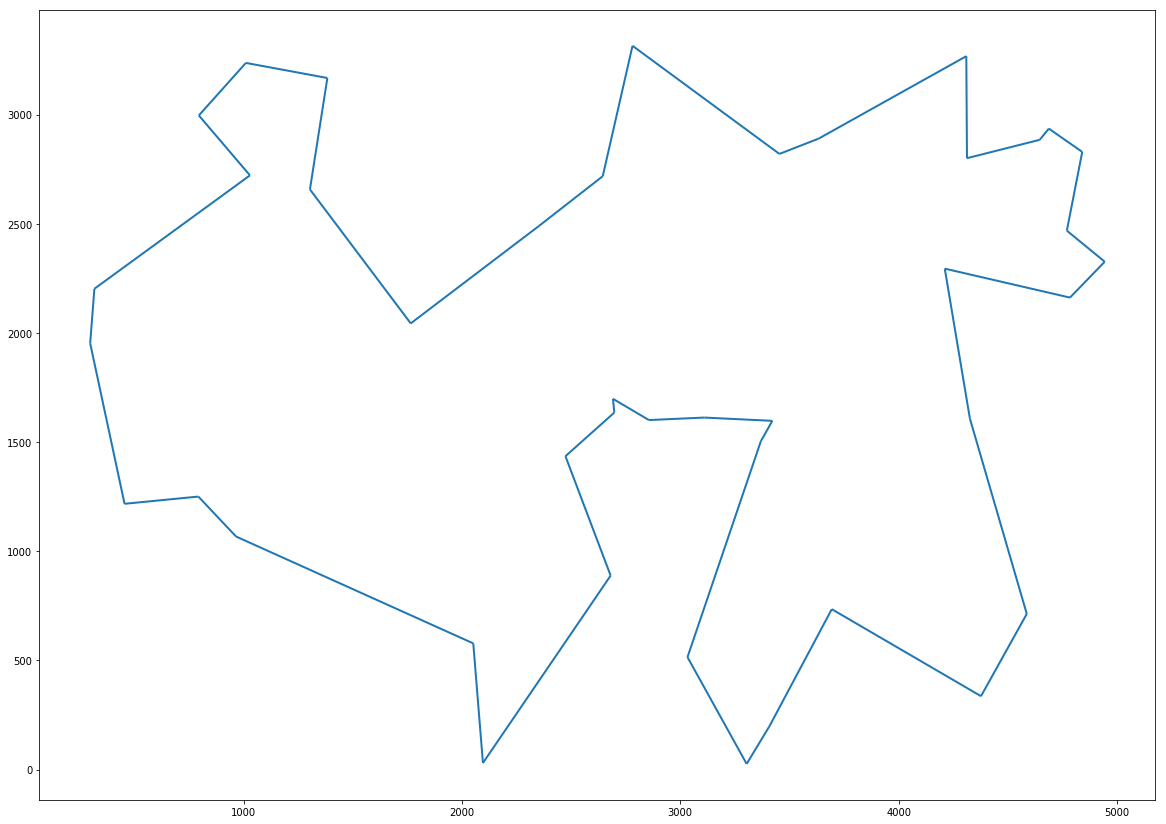

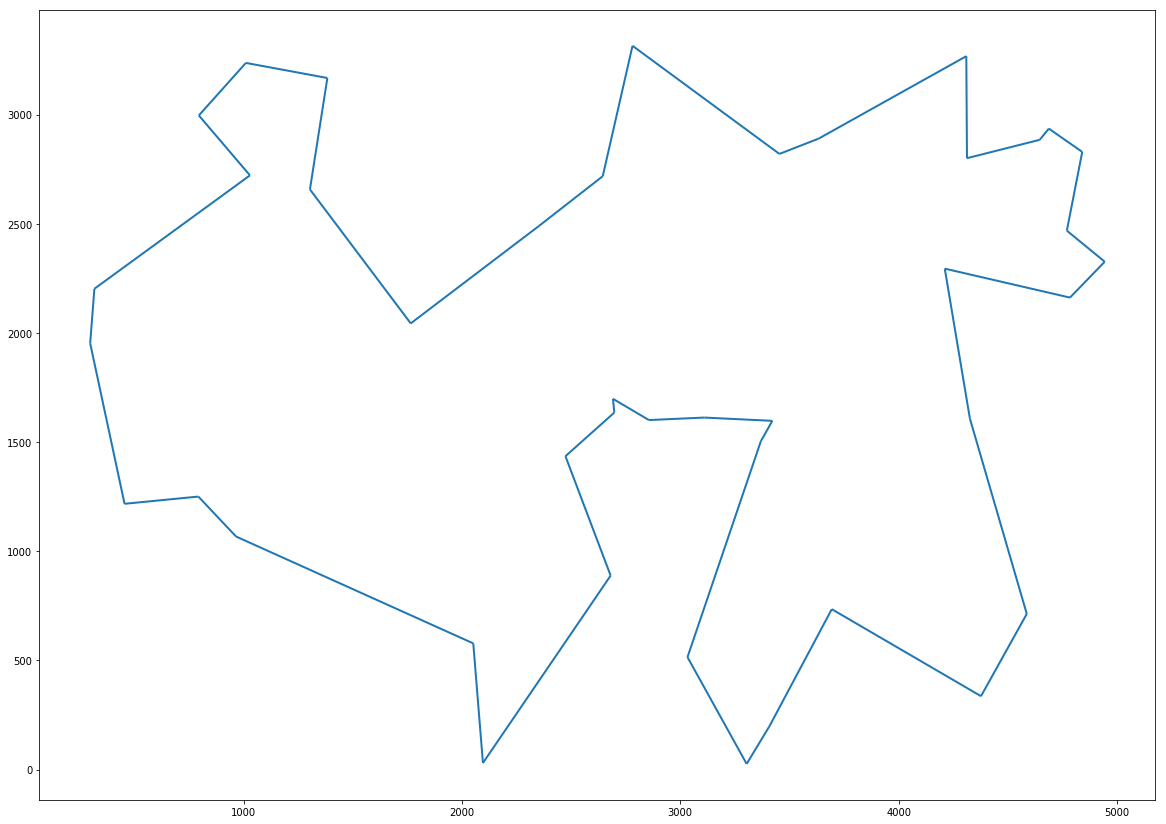

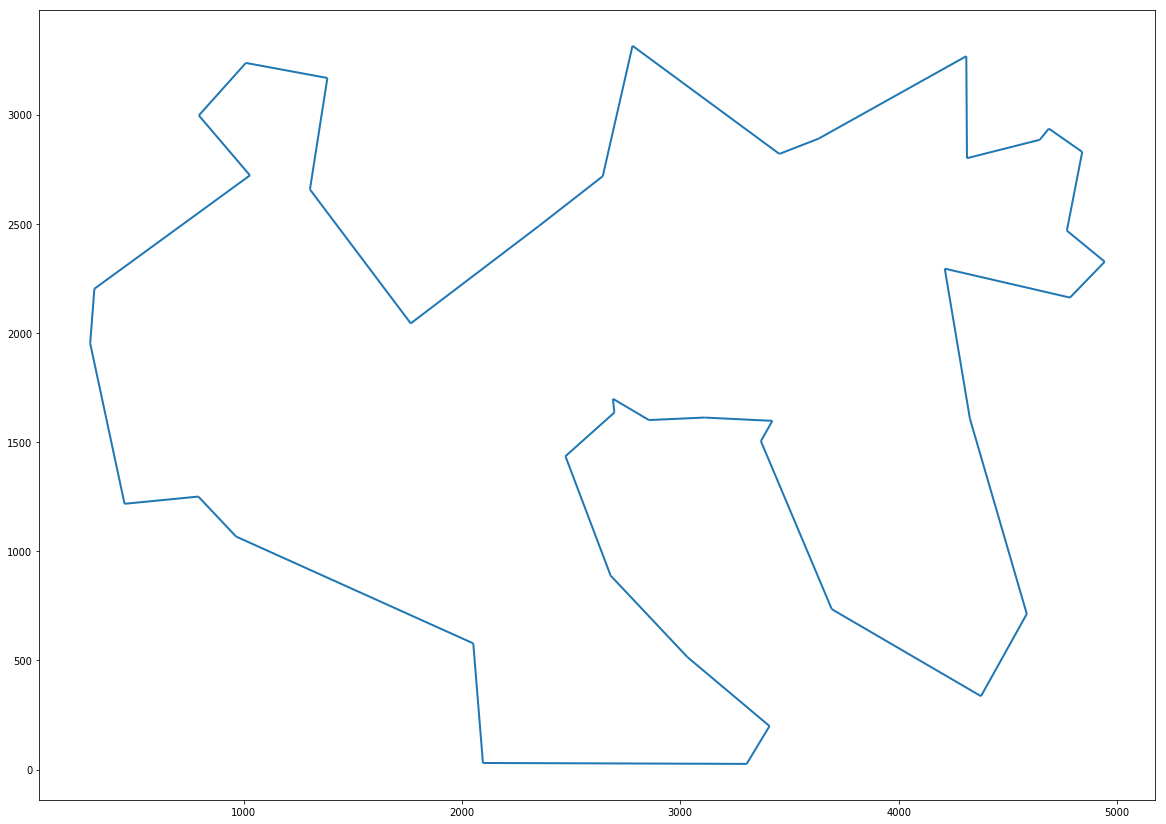

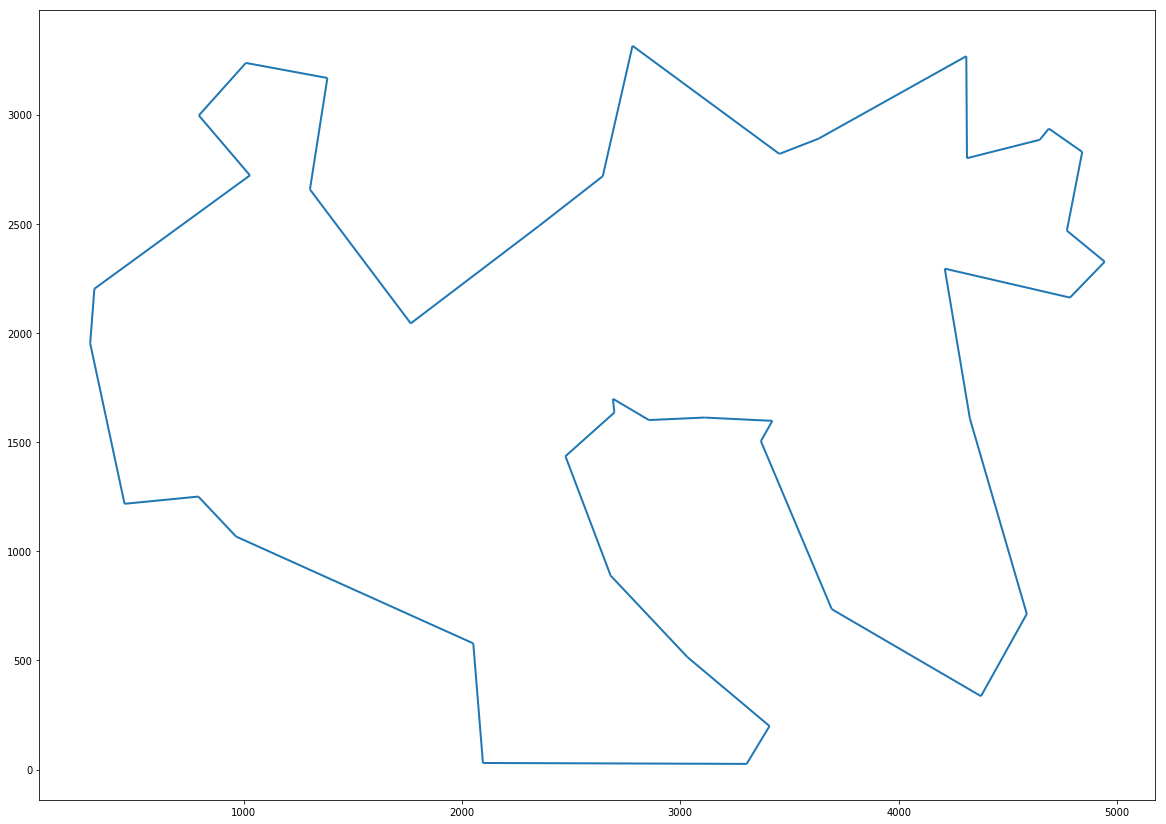

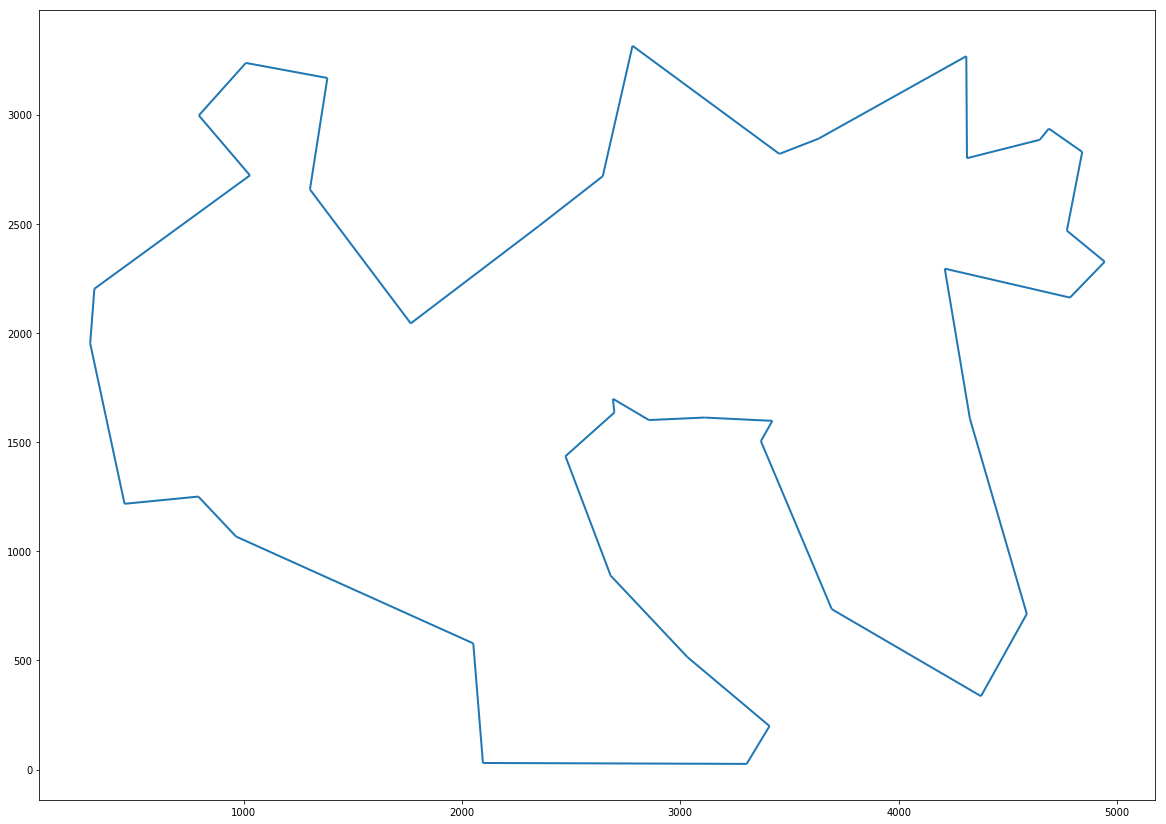

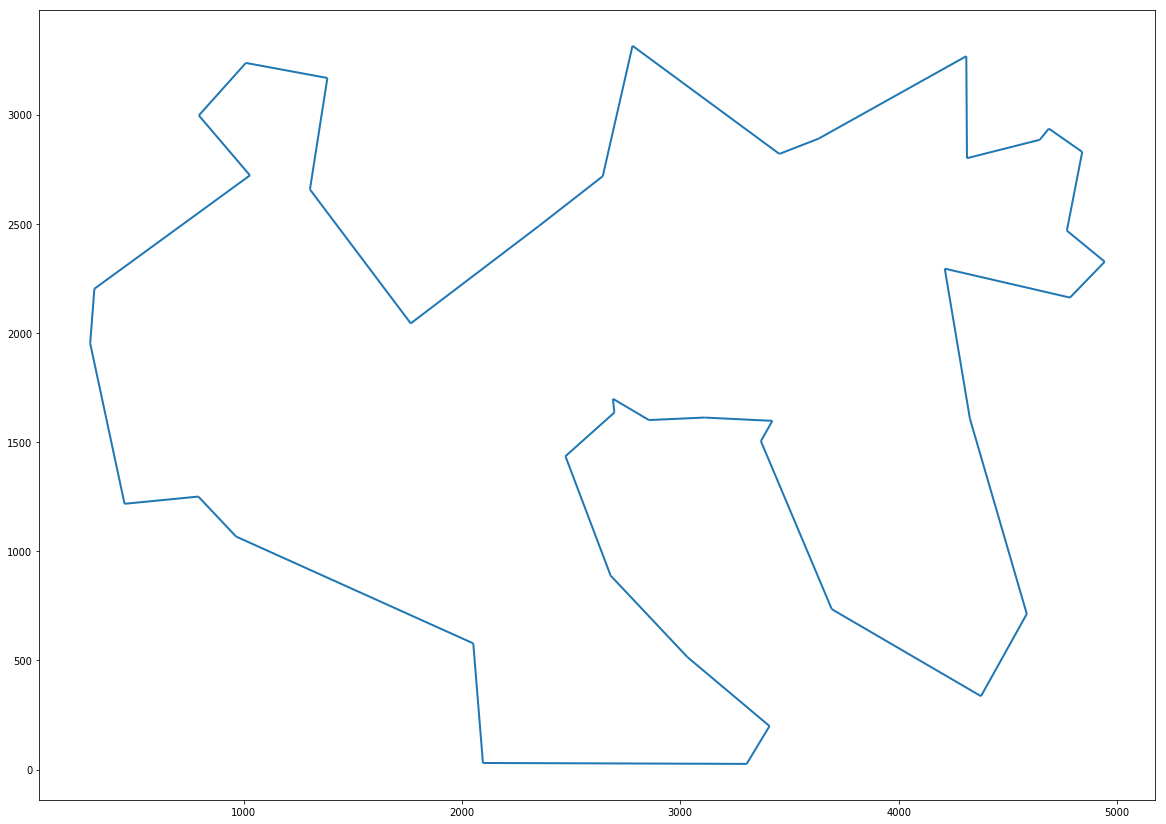

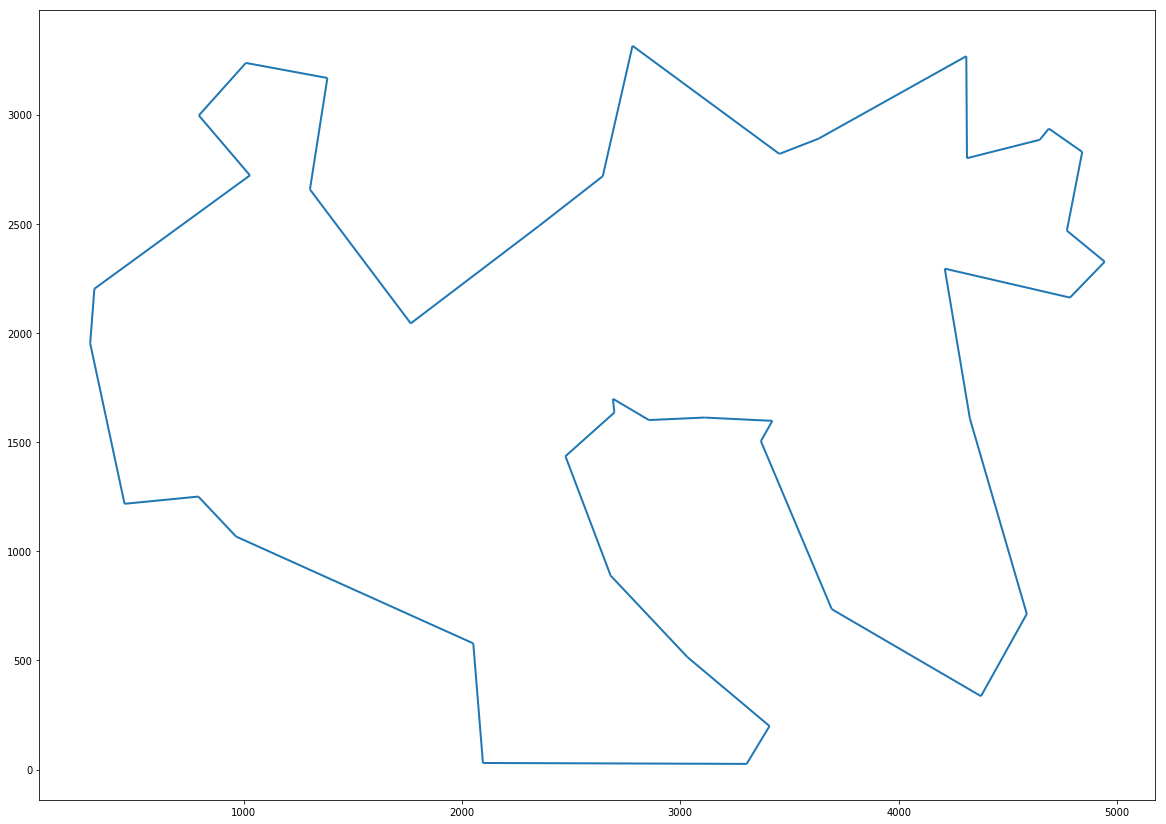

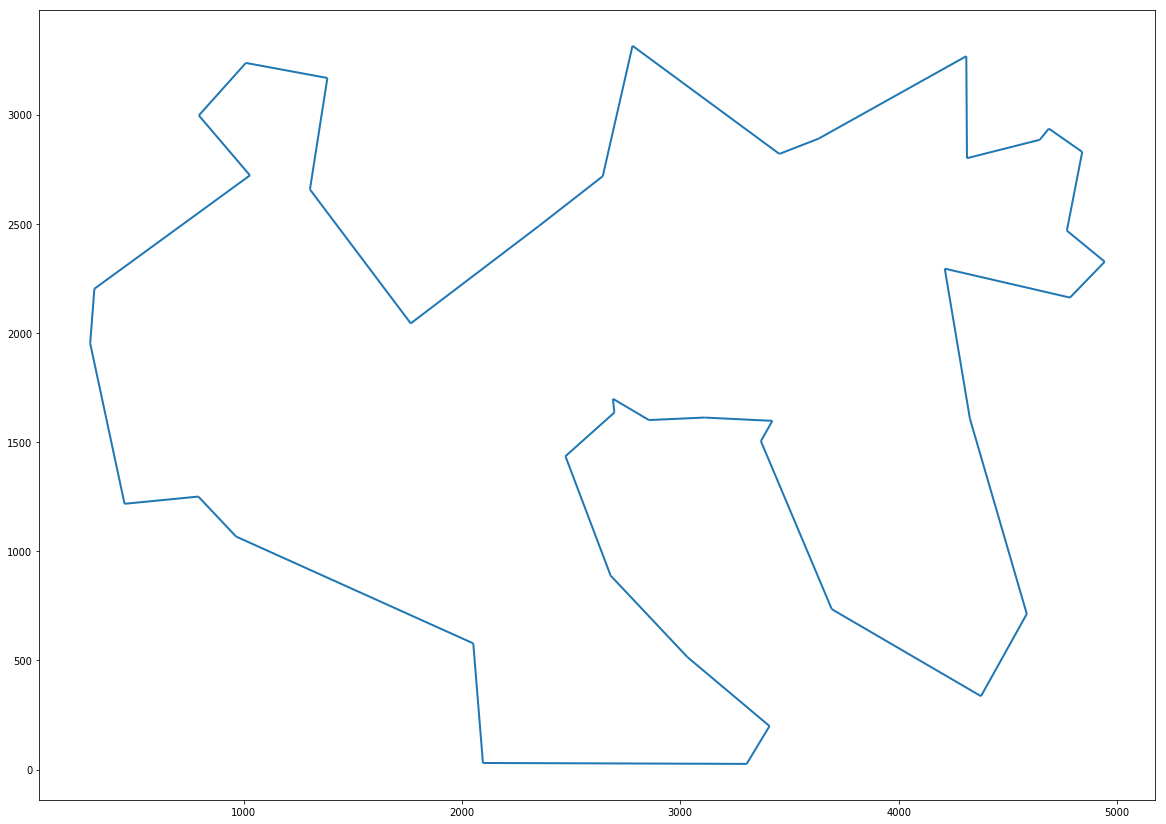

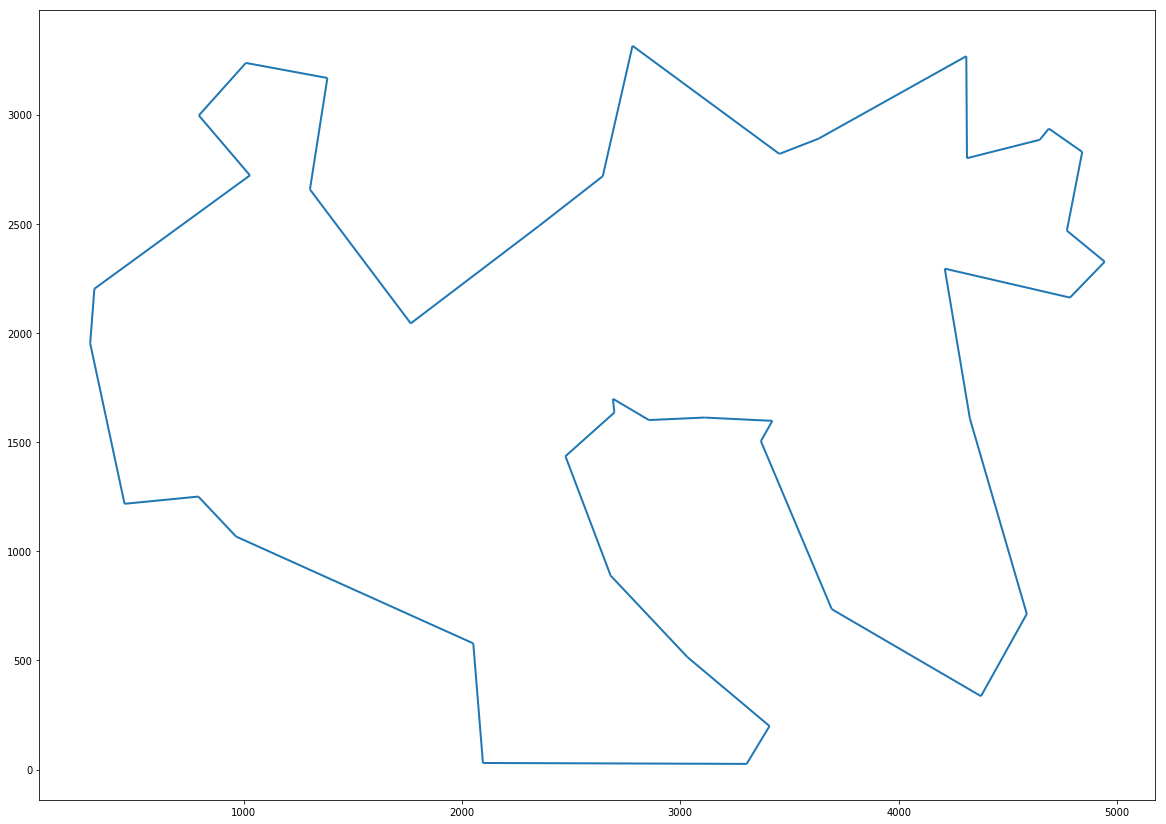

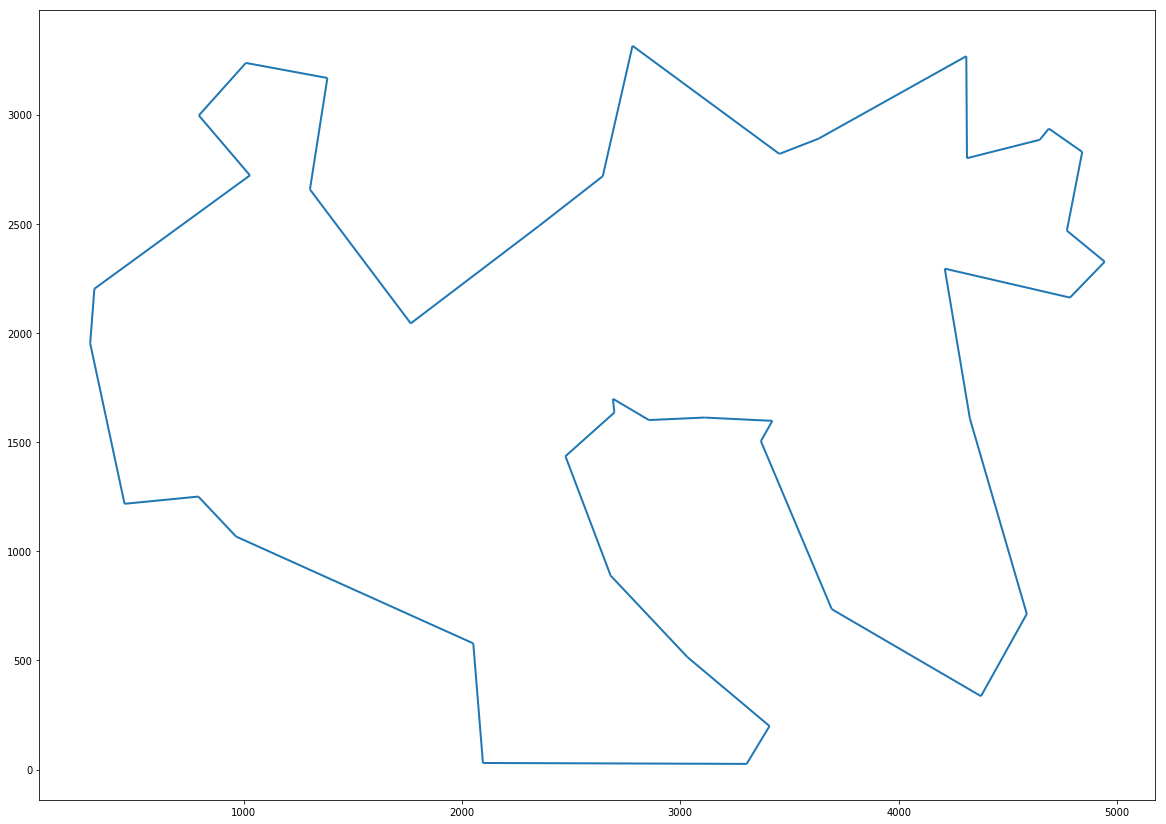

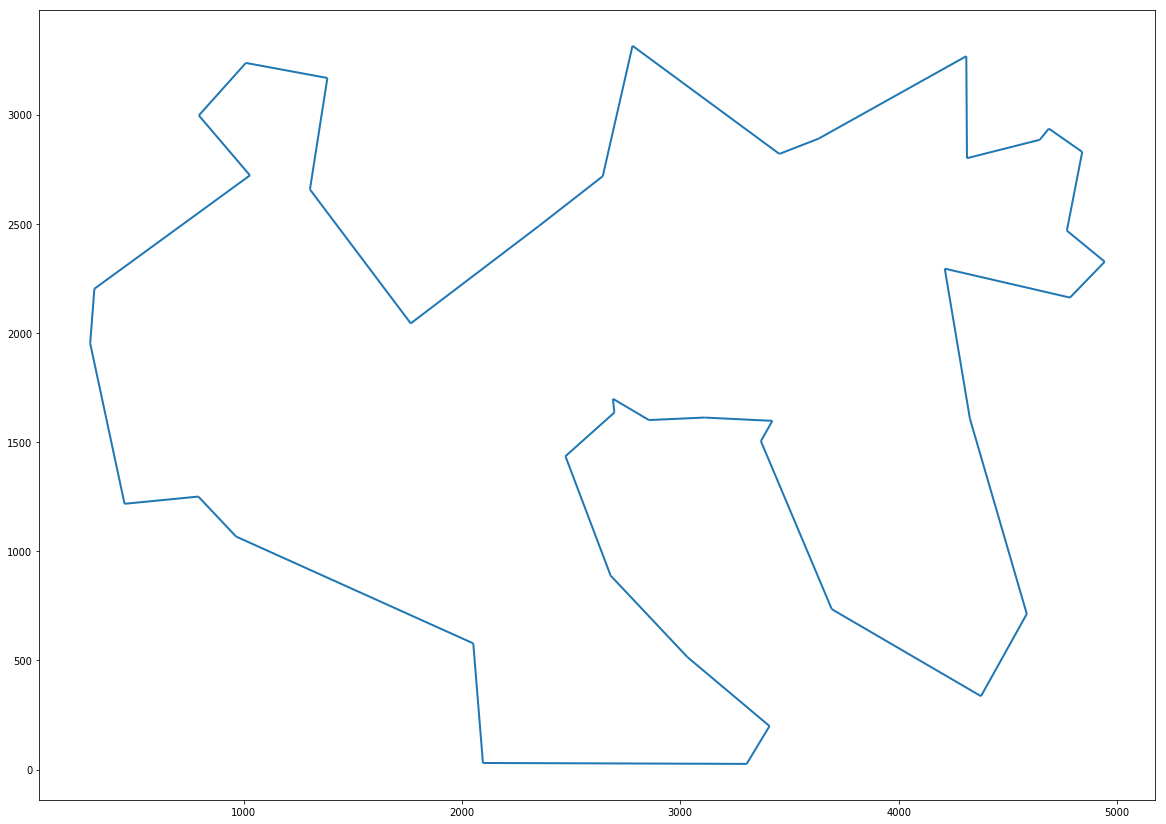

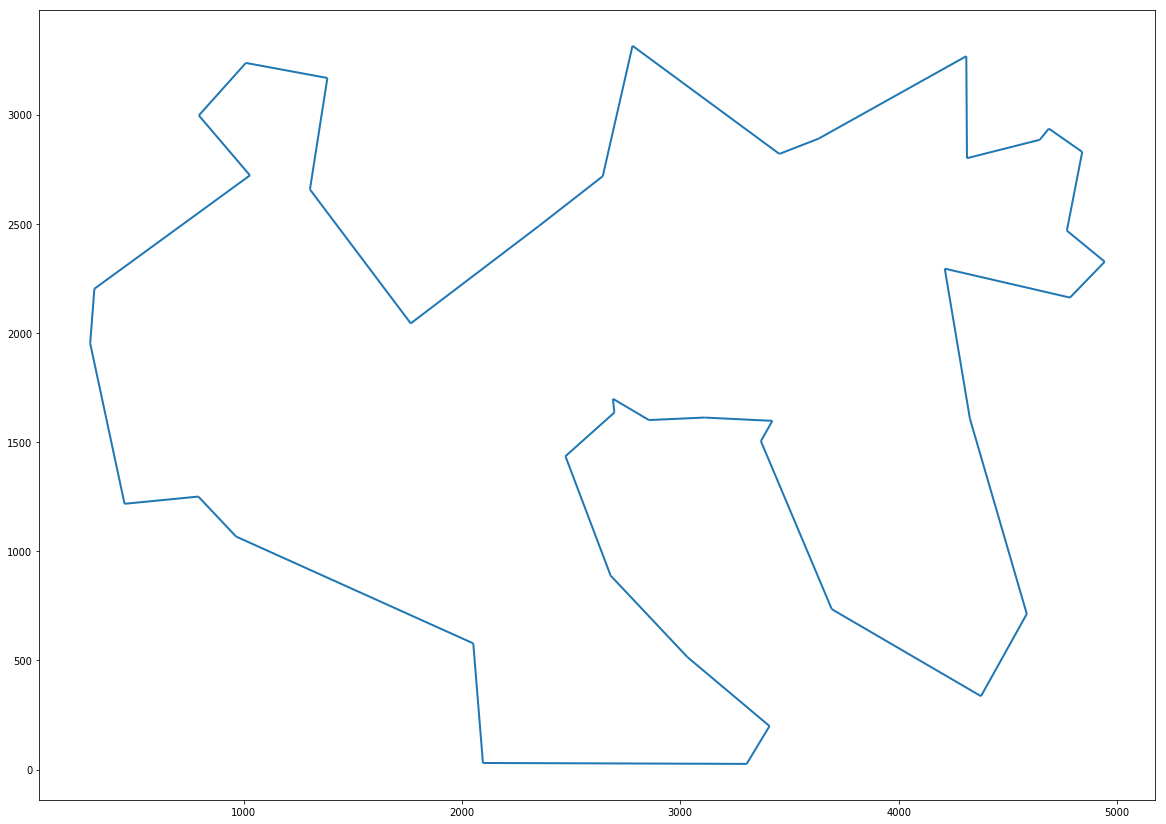

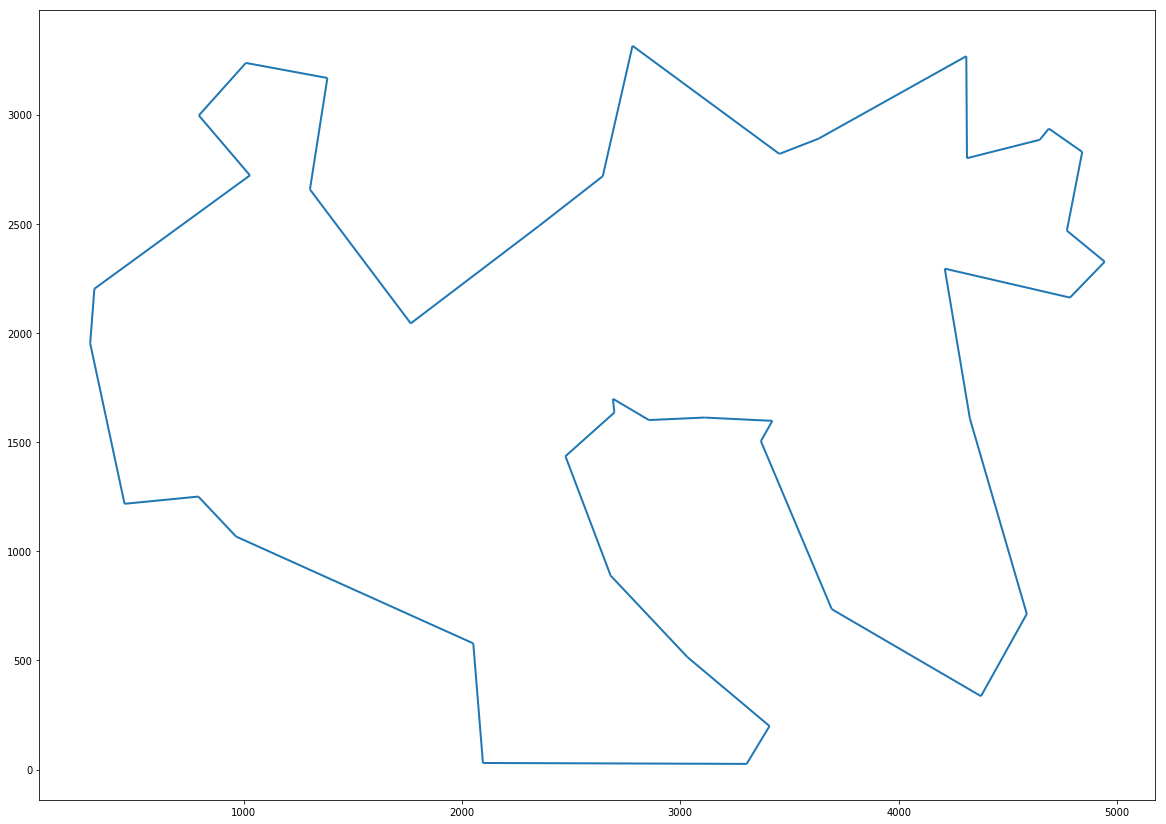

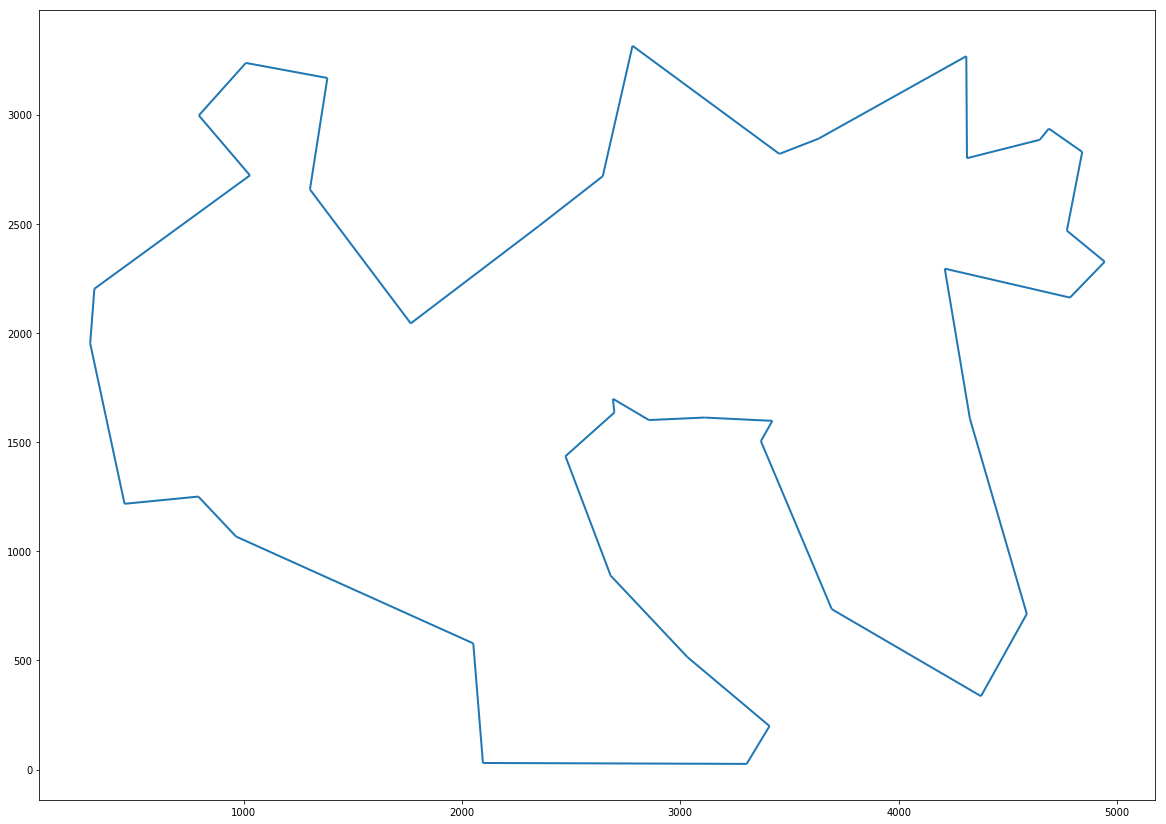

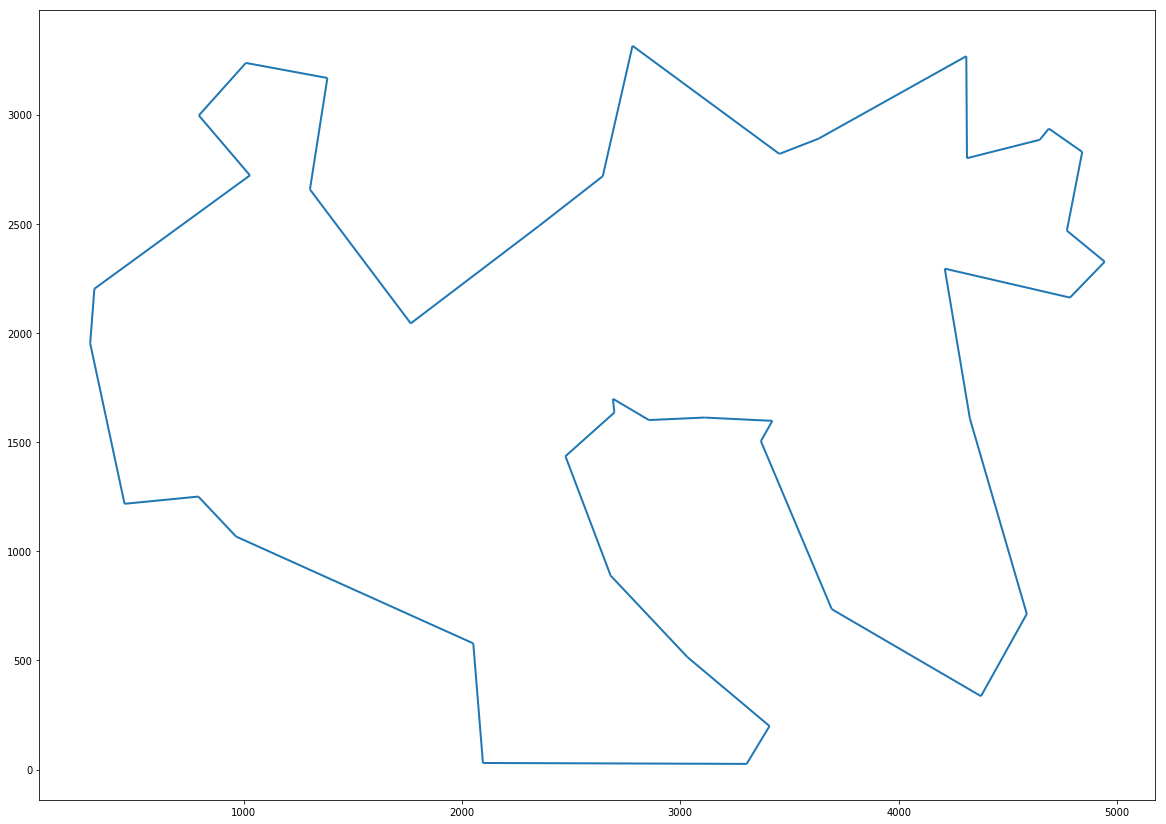

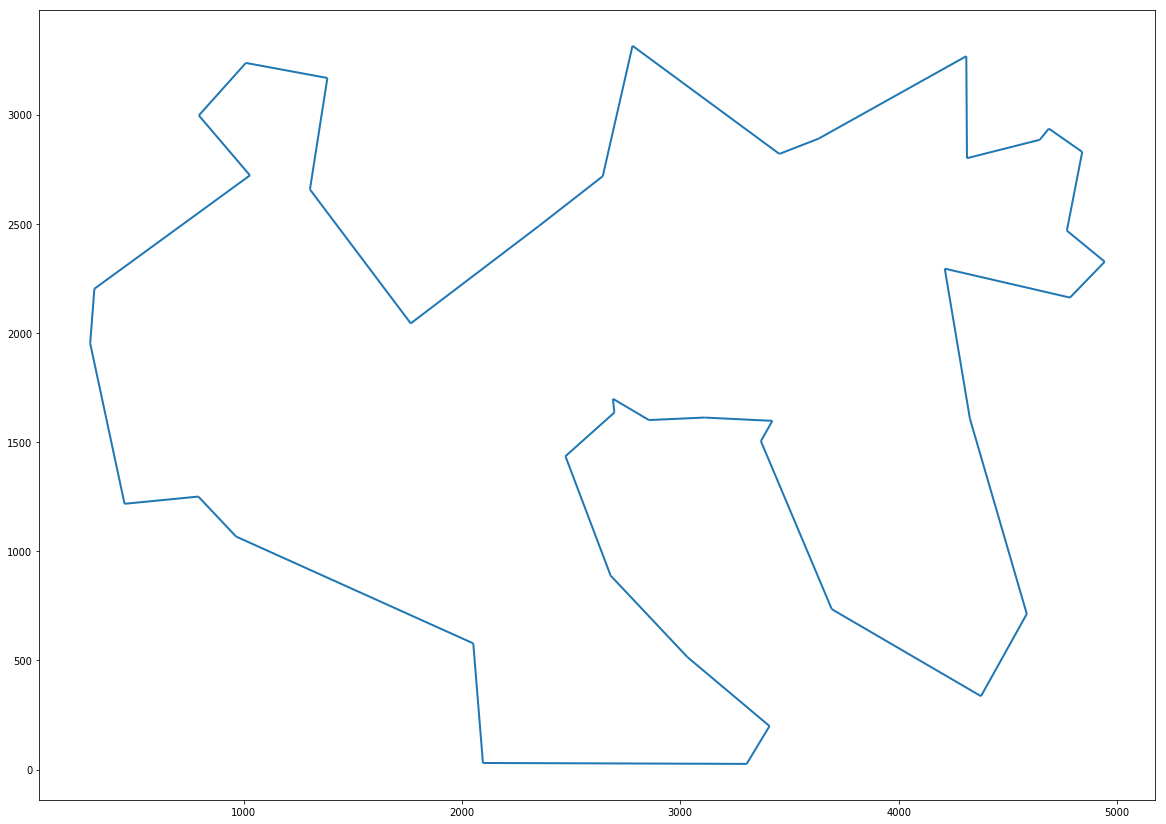

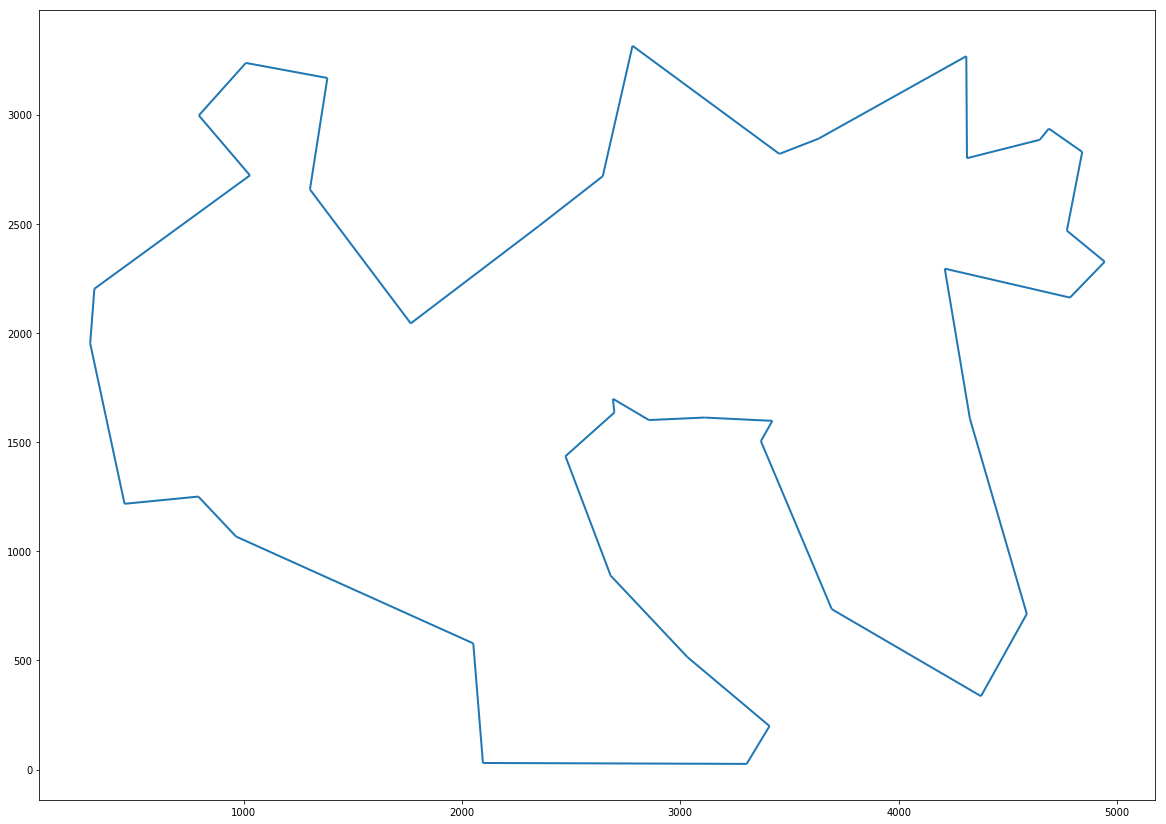

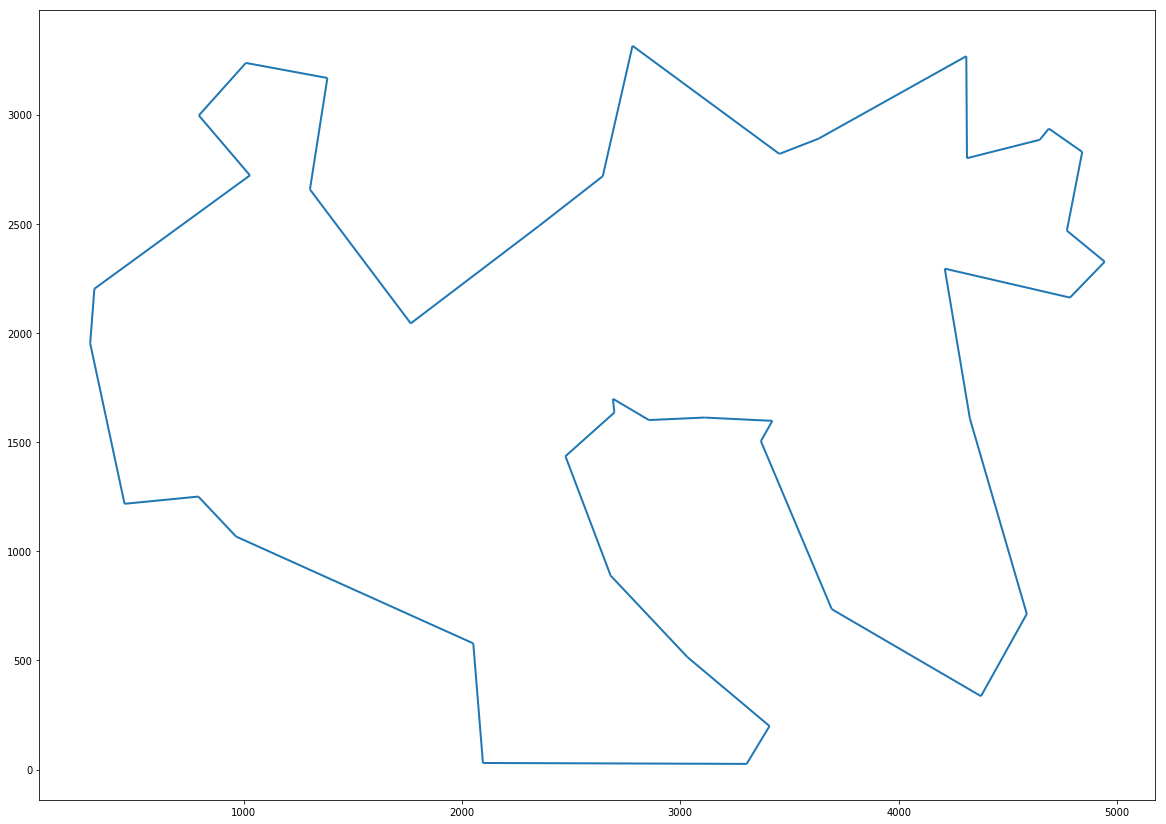

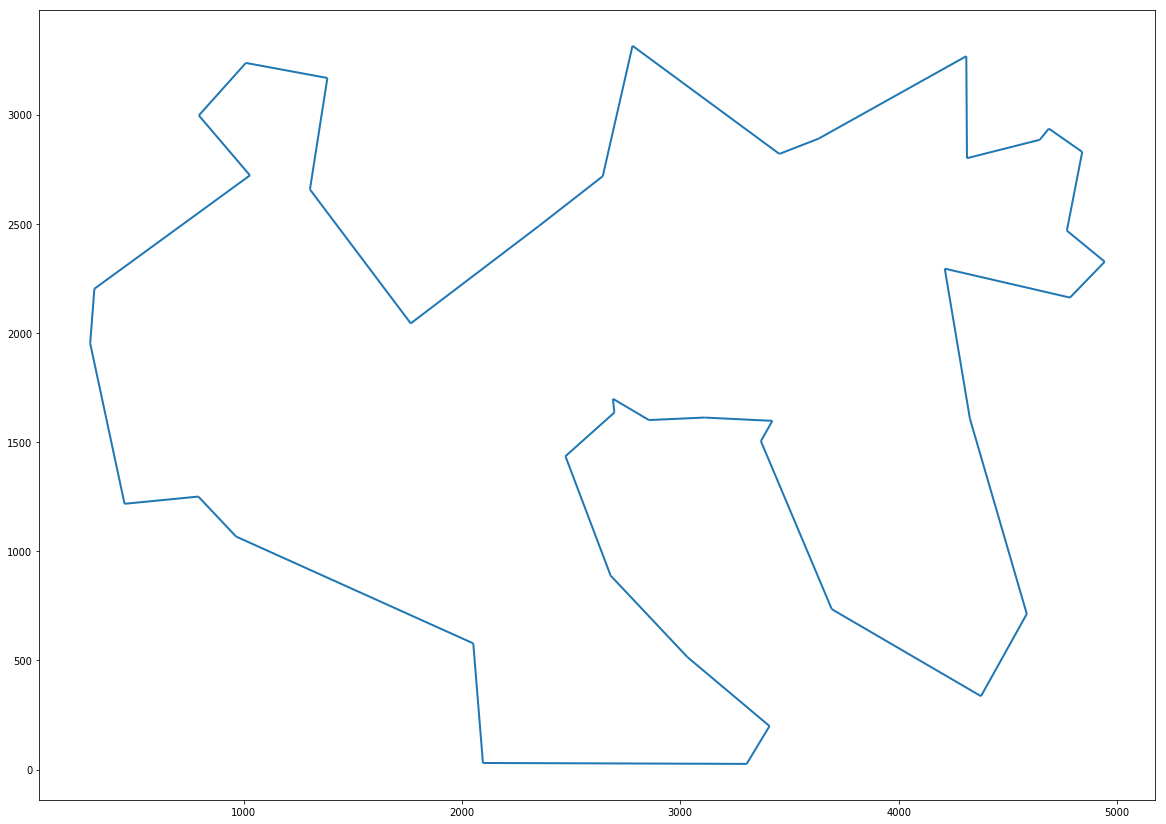

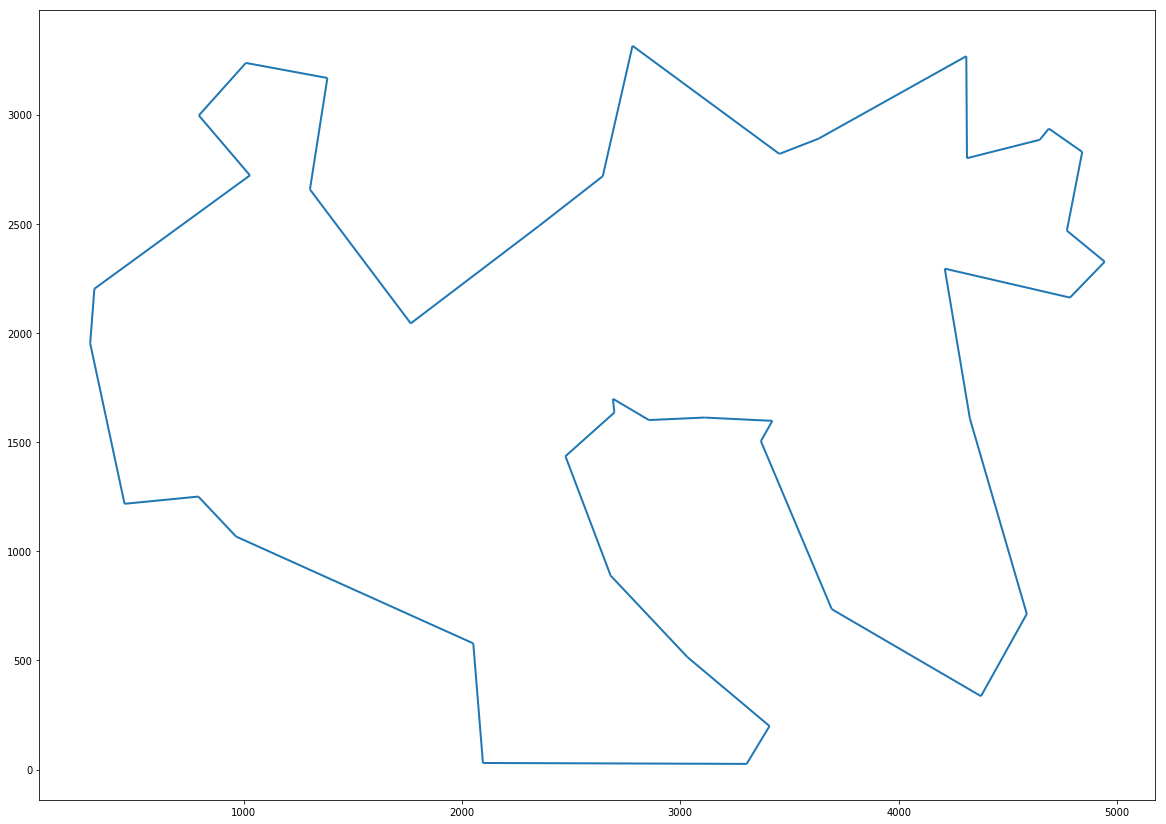

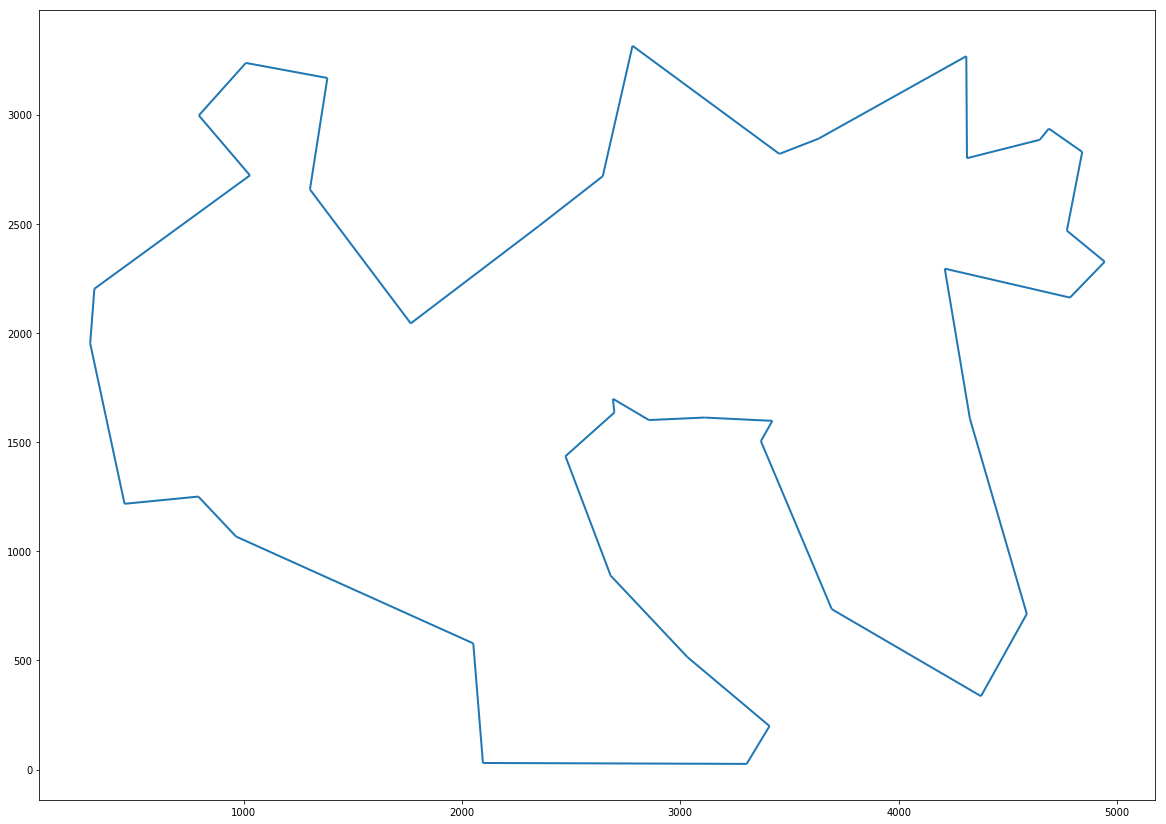

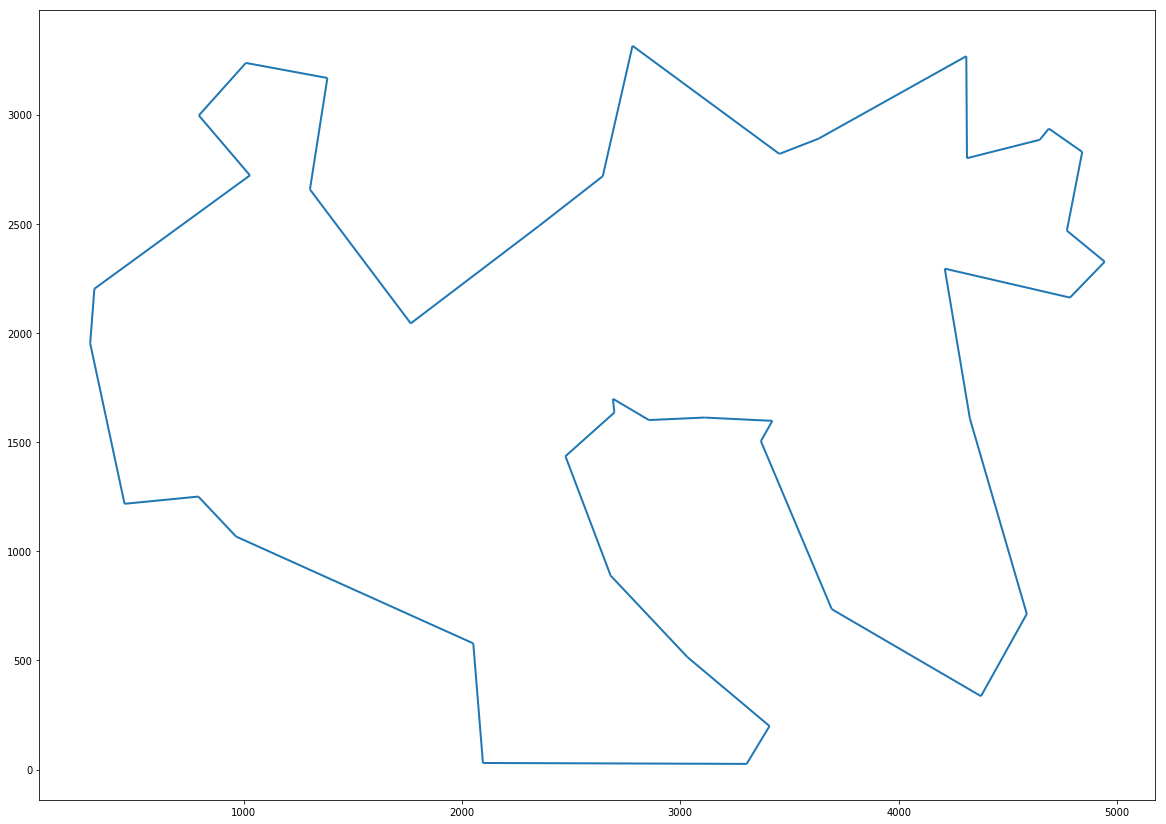

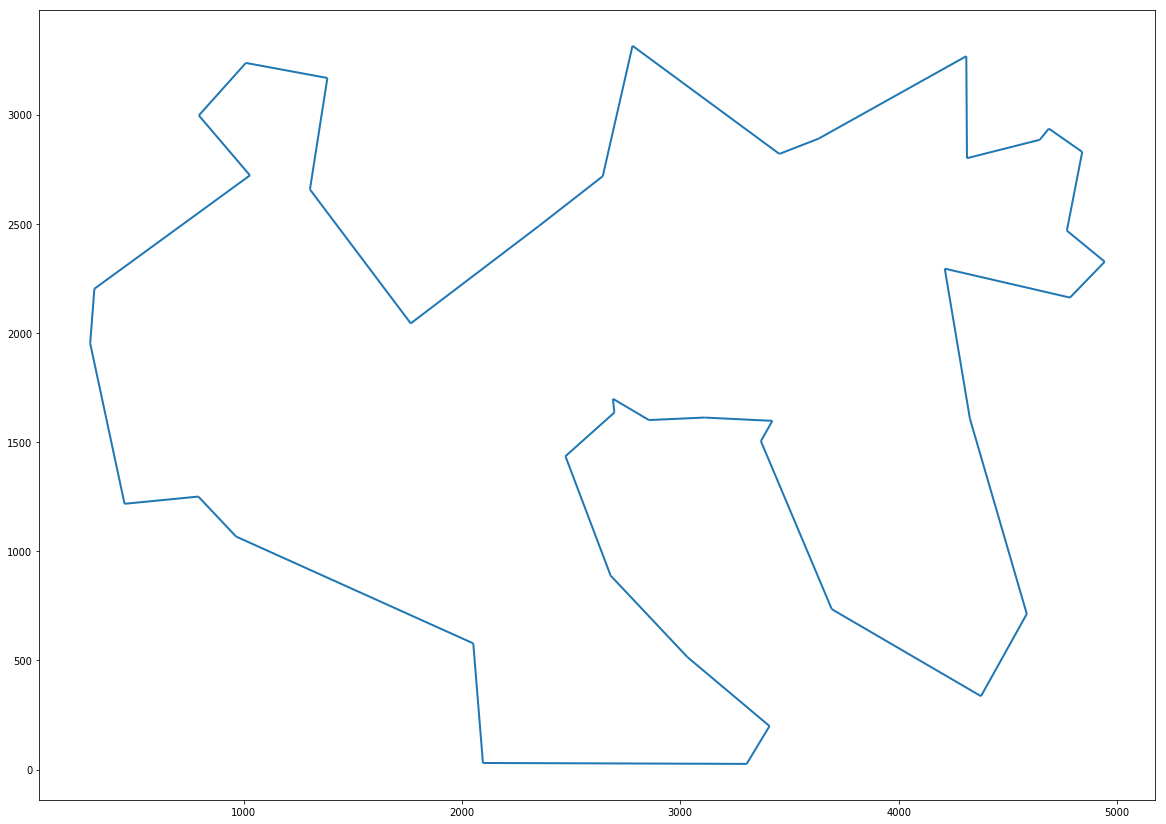

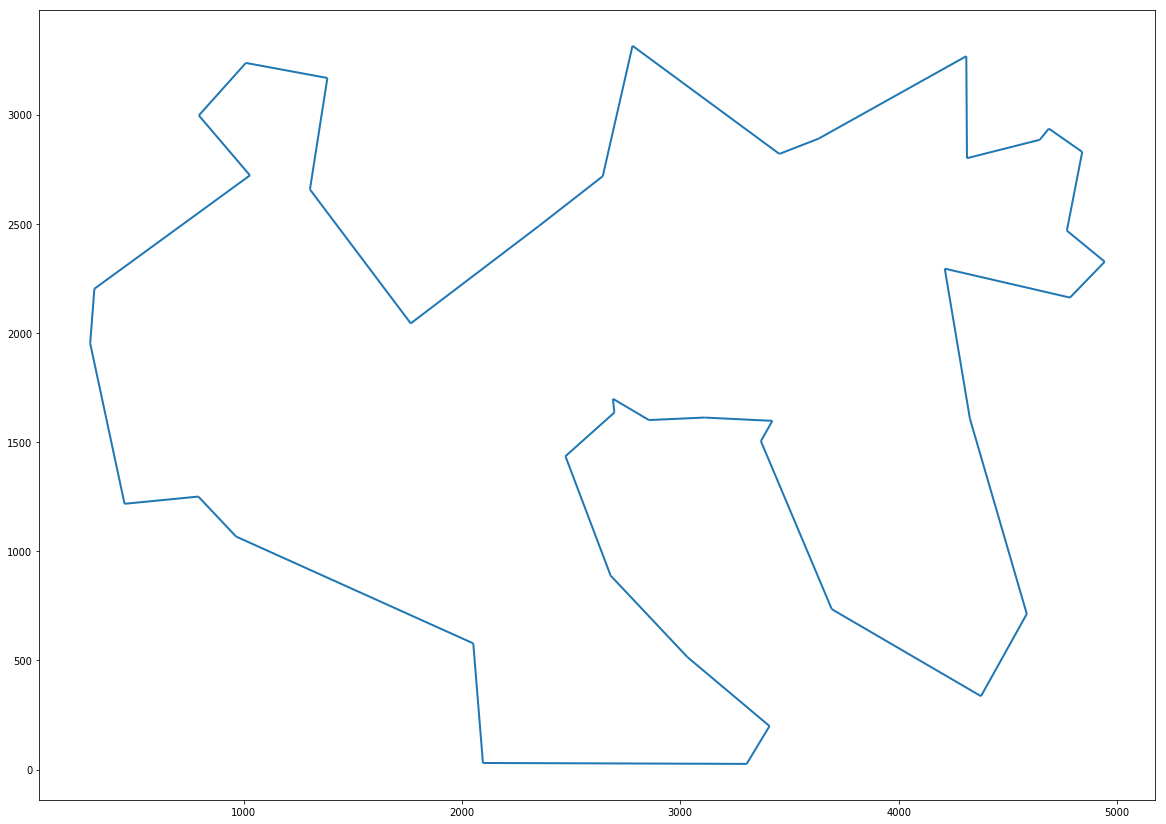

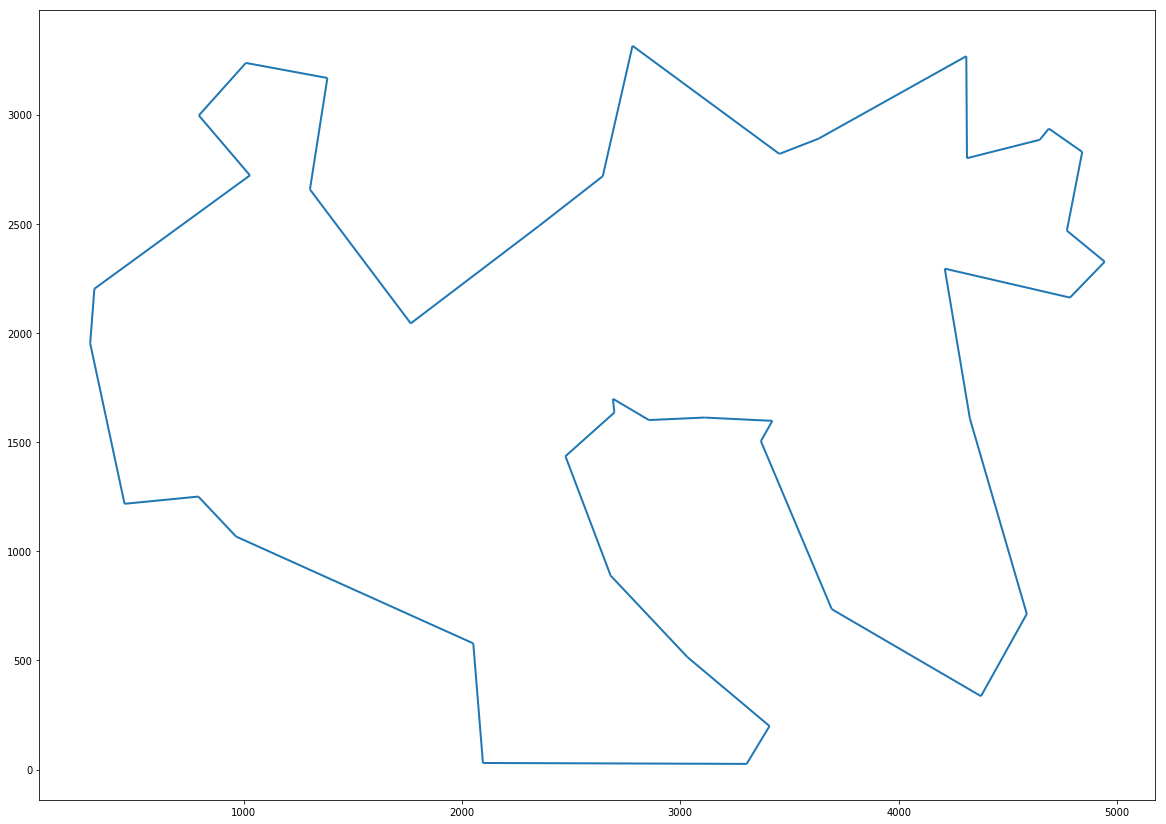

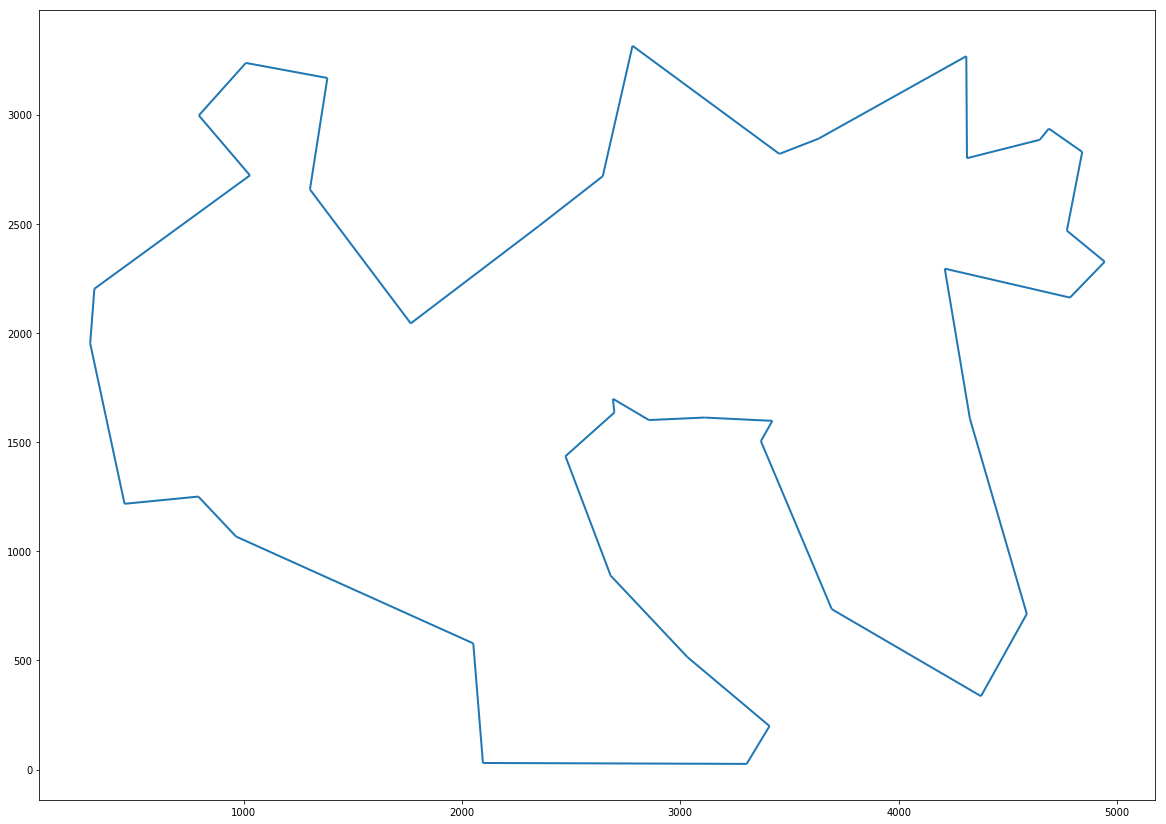

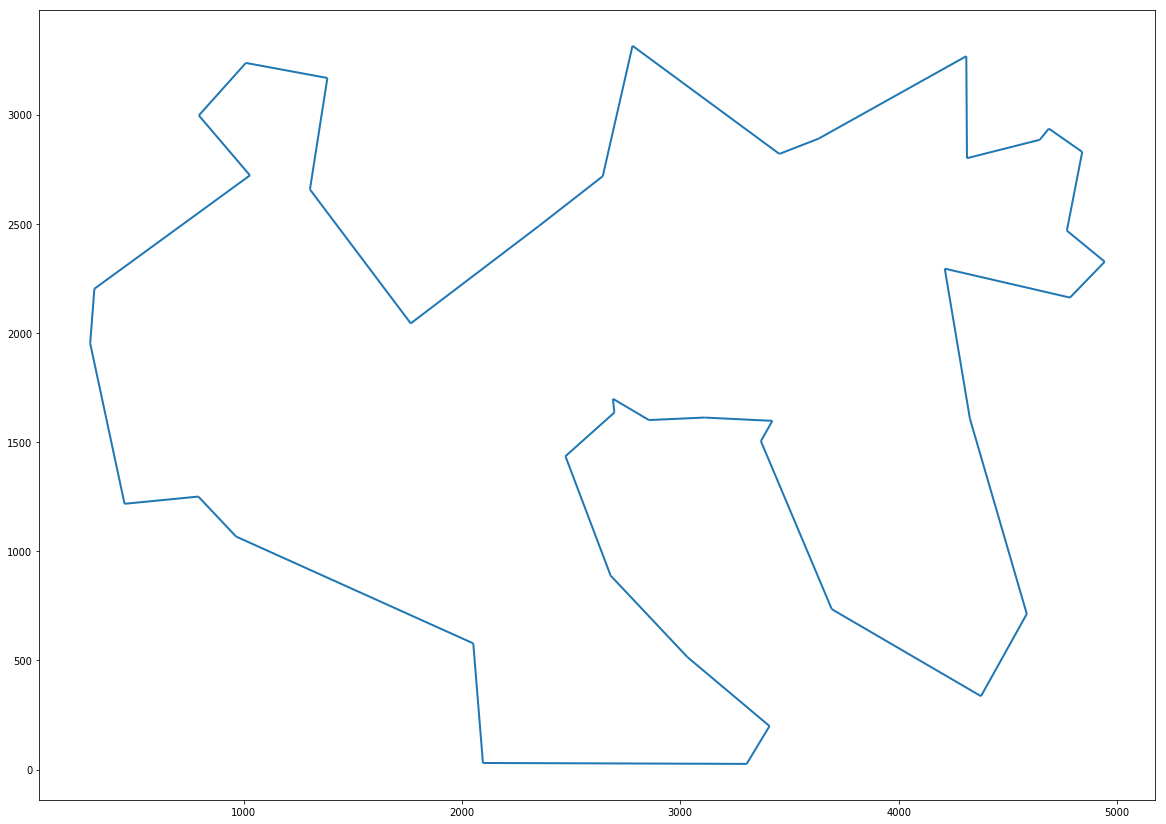

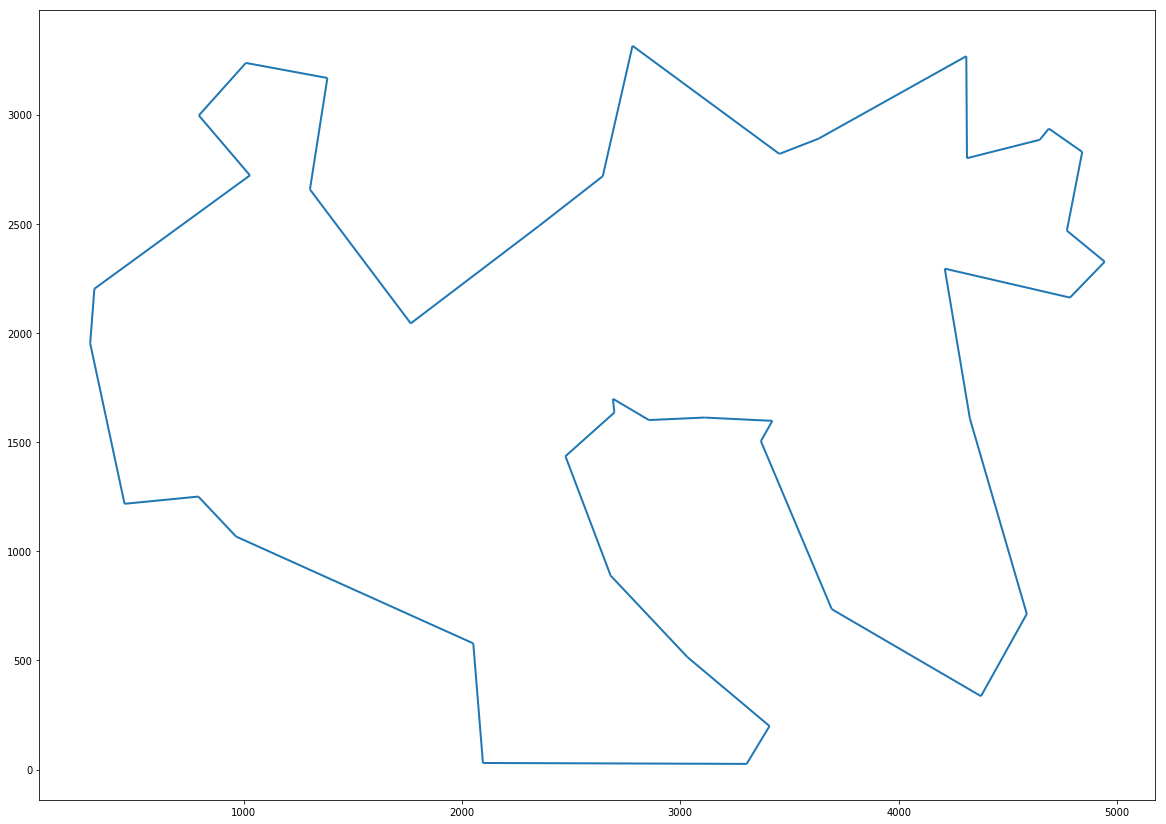

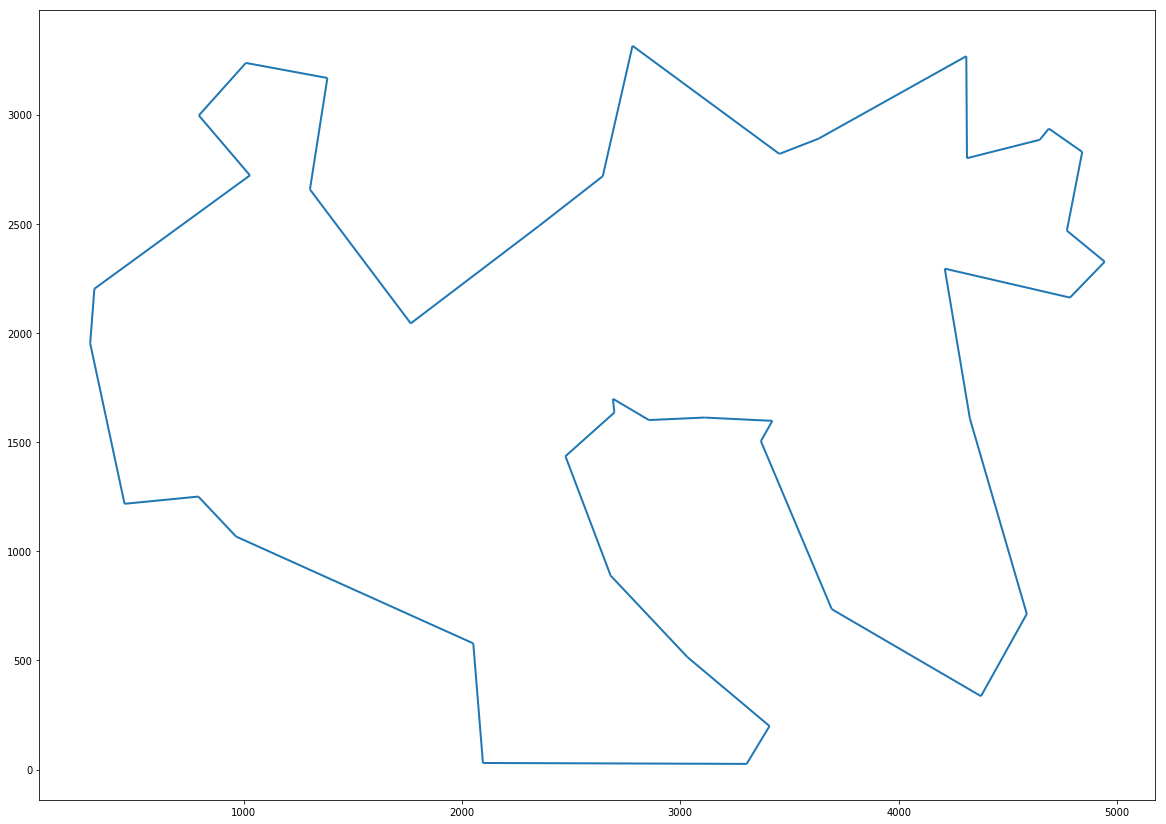

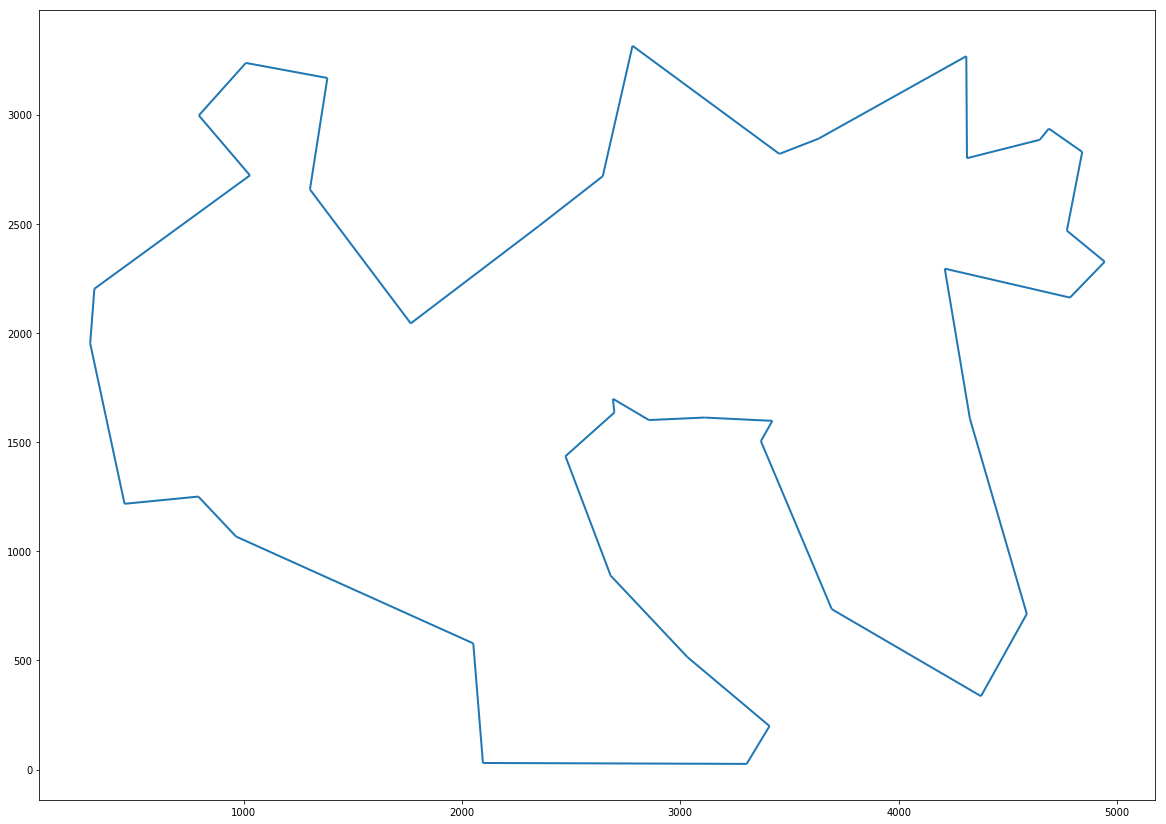

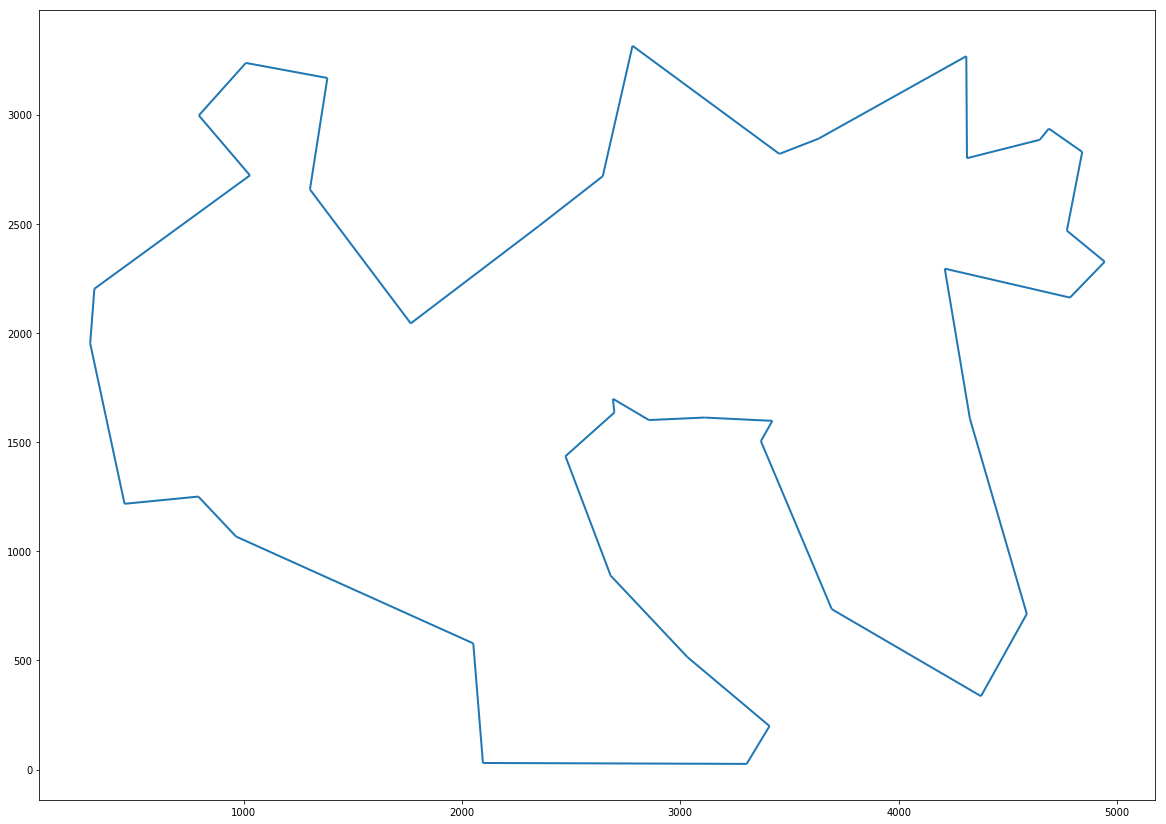

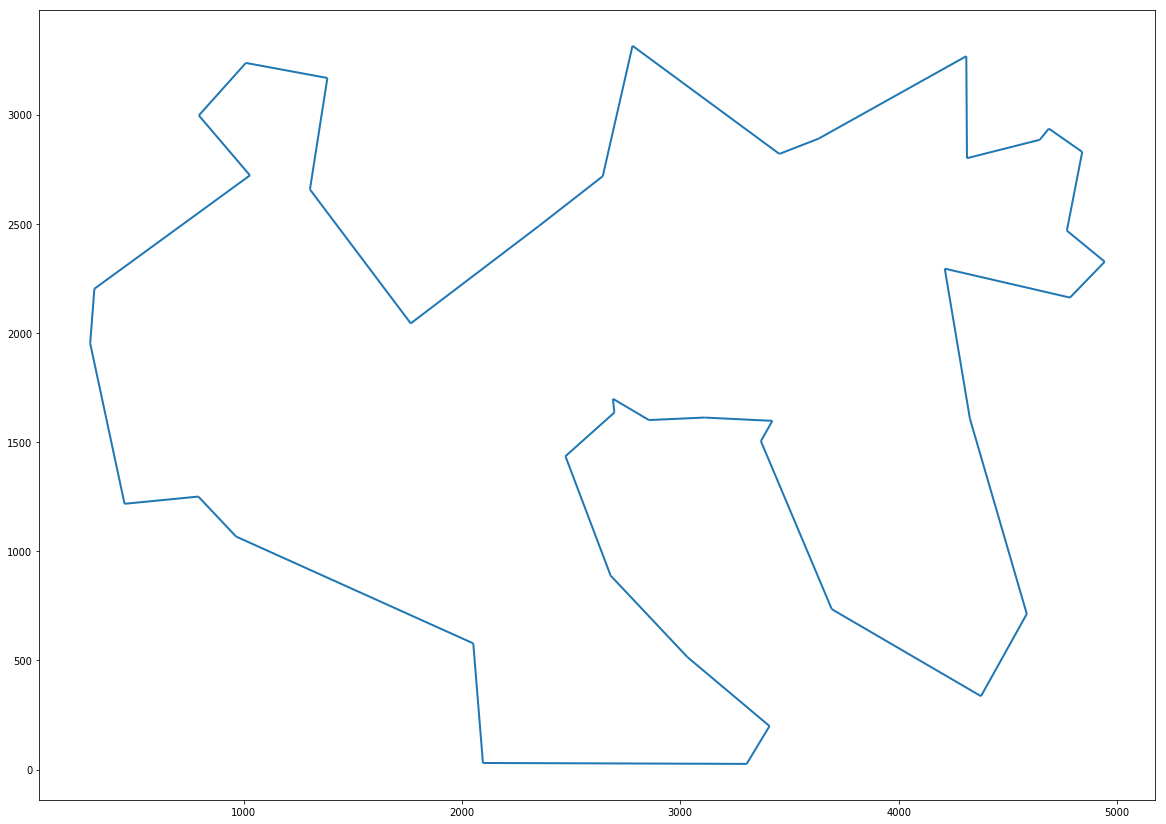

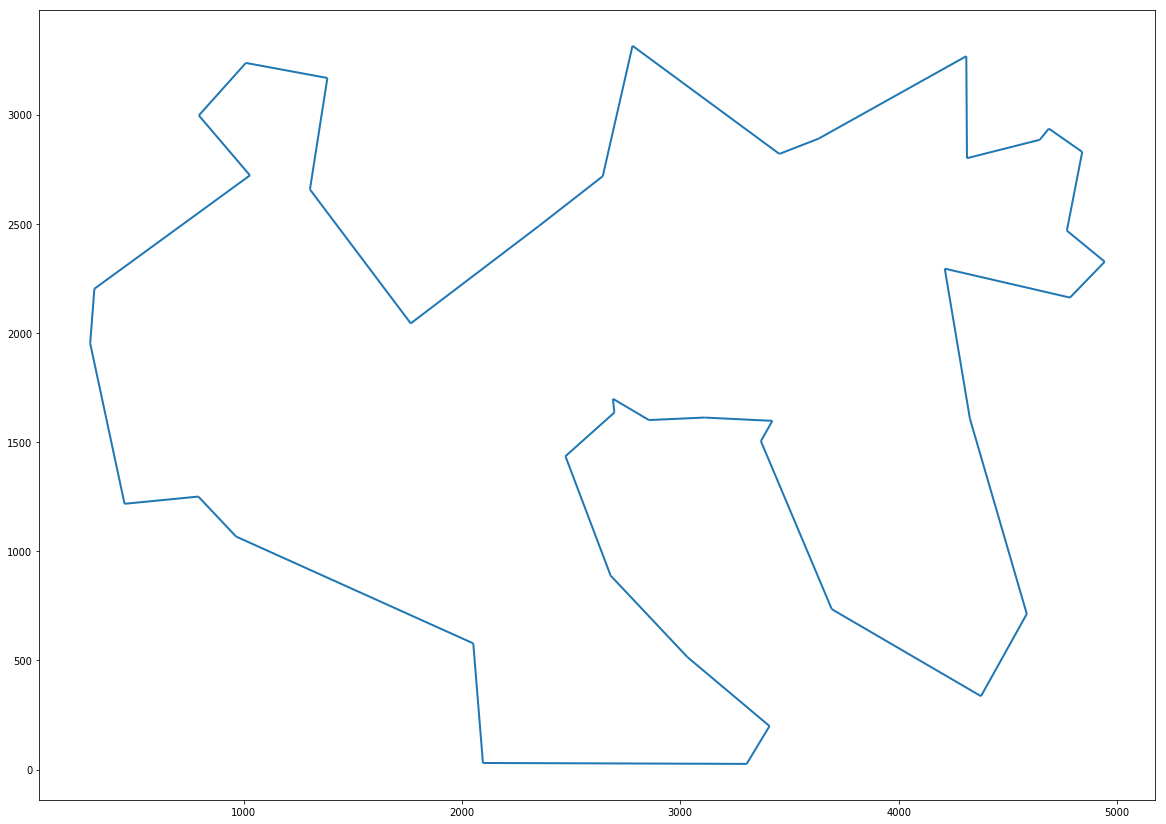

In [225]:
for i in range(nGen):
    population = sorted(population, key=lambda x: x.fitness, reverse=True)
    for j in range(len(population)):
        population[j].rank = get_rank(popSize, SP, j)
    population = sorted(population, key=lambda x: x.rank, reverse=False)
        
    print("Gen {} - Best: {}".format(i, population[-1].fitness))
    
    if np.random.random() < mut_rate:
        parent = population[-1] 
        child = mutate(parent)
    else:
        p1 = population[-1] 
        p2 = population[-2] 
        child = crossover(p1, p2)

    child.path = run_2opt(Tour(child.path))
    child.fitness = Tour(child.path).score()
    
    print(child.fitness)
    if child.fitness < population[0].fitness:
        population[0] = child
    
    distances = plot_path(population[-1].path, cities[["X", "Y"]].values)

In [410]:
Best: 20546.52

In [36]:
def plot_path(path, coordinates, k=0):
    # Plot tour
    lines = []
    distances = [] 
    for i in range(1, len(path)):
        line = [coordinates[path[i-1]], coordinates[path[i]]]
        (x1, y1), (x2, y2) = line
        distance = np.sqrt((x1-x2)**2 + (y1-y2)**2)
        distances.append(distance)   
        if distance > 16.4:
            lines.append(line)
        
    lc = mc.LineCollection(lines, linewidths=2)
    fig, ax = plt.subplots(figsize=(20,20))
    ax.set_aspect('equal')
    plt.grid(False)
    ax.add_collection(lc)
    ax.autoscale()
    return distances

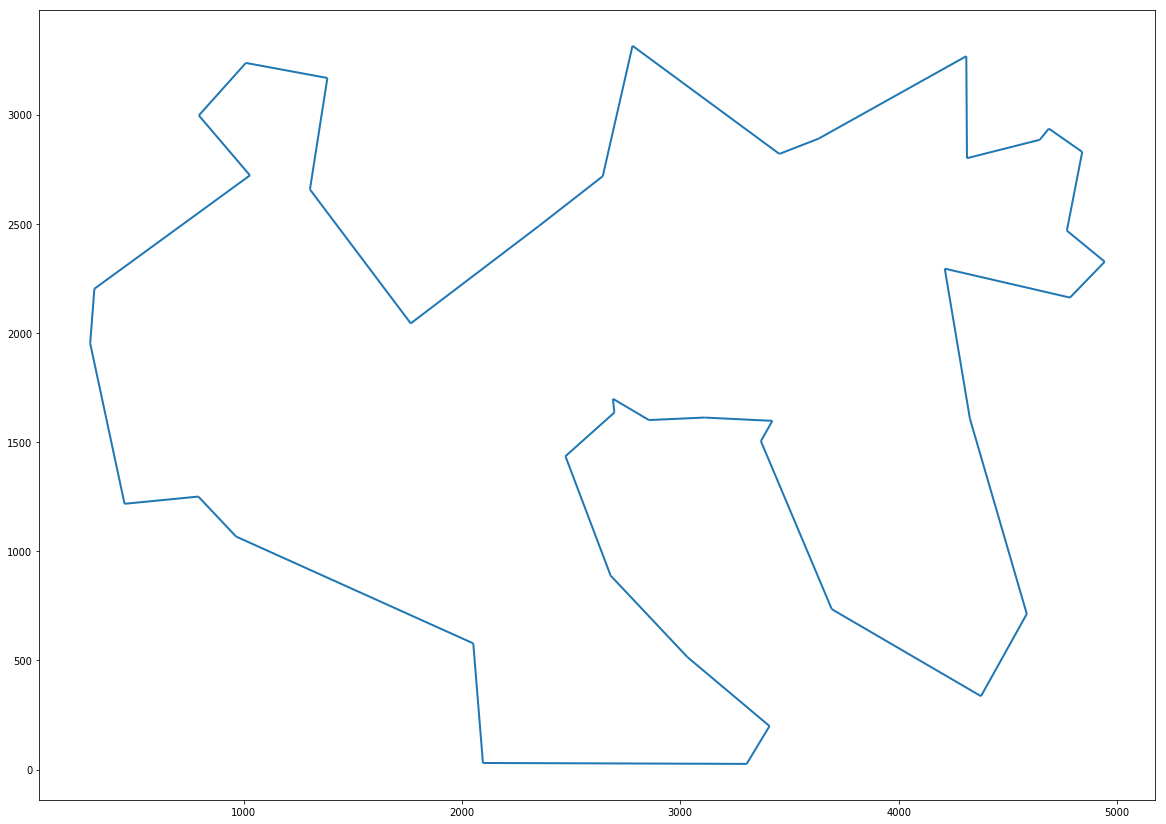

In [405]:
distances = plot_path(population[-1].path, cities[["X", "Y"]].values)

In [29]:
class Individual():
    def __init__(self, path):
        self.path = path
        self.fitness = Tour(path).score()
        self.ranking = 0


In [33]:
def get_rank(pop_size, selection_pressure, position):
    rank = 2 - selection_pressure + 2*(selection_pressure-1)*((position-1)/(pop_size-1))
    return rank

In [27]:
def generate_ind():
    indiv = list(range(1,42))
    indiv = np.random.permutation(indiv)
    indiv = np.insert(indiv, 0, 0)
    indiv = np.insert(indiv, len(indiv), 0)
    indiv = list(indiv)
    
    assert indiv[0]==indiv[-1]==0
    assert len(set(indiv))==len(indiv)-1
    
    return Individual(indiv)

In [34]:
def mutate(indiv):
#    i, ii, j, jj, k, kk, l, ll = 3, 4, 9, 10, 28, 29, 35, 36
    
    i = np.random.randint(1, int(0.25*len(indiv.path)))
    ii = i+1
    
    j = np.random.randint(int(0.25*len(indiv.path))+1, int(0.50*len(indiv.path)))
    jj = j+1
    
    k = np.random.randint(int(0.50*len(indiv.path))+1, int(0.75*len(indiv.path)))
    kk = k+1
    
    l = np.random.randint(int(0.75*len(indiv.path))+1, len(indiv.path)-2)
    ll = l+1
    
    new_genome = indiv.path[0:i+1]

    new_genome.append(indiv.path[kk])
    new_genome.extend(indiv.path[kk+1:l+1])
    new_genome.append(indiv.path[jj])
    new_genome.extend(indiv.path[jj+1:k+1])
    new_genome.append(indiv.path[ii])
    new_genome.extend(indiv.path[ii+1:j+1])
    new_genome.append(indiv.path[ll])
    new_genome.extend(indiv.path[ll+1:])


    assert len(new_genome)==len(indiv.path)
    assert new_genome[0]==new_genome[-1]==0
    assert len(set(new_genome))==len(new_genome)-1
    
    return Individual(new_genome)

In [35]:
def crossover(p1, p2):
    
    parent1, parent2 = p1.path, p2.path
    rnd_city = np.random.randint(low=1, high=42)
    offspring = [rnd_city]
    rnd_city_in_parent1 = parent1.index(rnd_city)
    rnd_city_in_parent2 = parent2.index(rnd_city)
    city_included = [rnd_city]
    STOP = False
    idx1 = rnd_city_in_parent1 + 1
    idx2 = rnd_city_in_parent2 - 1
    while not STOP:
        if idx1 < len(parent1)-1: ## -1 for the 0 
            if parent1[idx1] in city_included:
                STOP = True
                break
            offspring.append(parent1[idx1])
            city_included.append(parent1[idx1])
            idx1+=1
        else:
            break

        if idx2 > 0: ## > strict for the 0
            if parent2[idx2] in city_included:
                STOP = True
                break
            offspring.insert( 0,parent2[idx2])
            city_included.append(parent2[idx2])
            idx2-=1
    for i in range(1, len(parent2)-1): ##-1 for the zero
        if parent2[i] not in city_included:
            offspring.append(parent2[i])
    offspring.append(0)
    offspring.insert(0, 0)
    
    assert len(offspring)==len(p1.path)
    assert offspring[0]==offspring[-1]==0
    assert len(set(offspring))==len(offspring)-1
    
    return Individual(offspring)

In [294]:
parent = population[-1] 
child = mutate(parent)
child
crossover(parent, child)

In [152]:
def reverse_segment_if_better(tour, i, j, k):
    "If reversing tour[i:j] would make the tour shorter, then do it."
    # Given tour [...A-B...C-D...E-F...]
    A, B, C, D, E, F = tour[i-1], tour[i], tour[j-1], tour[j], tour[k-1], tour[k % len(tour)]
    d0 = A.euclidean_dist(B) + C.euclidean_dist(D) + E.euclidean_dist(F)
    d1 = A.euclidean_dist(C) + B.euclidean_dist(D) + E.euclidean_dist(F)
    d2 = A.euclidean_dist(B) + C.euclidean_dist(E) + D.euclidean_dist(F)
    d3 = A.euclidean_dist(D) + E.euclidean_dist(B) + C.euclidean_dist(F)
    d4 = F.euclidean_dist(B) + C.euclidean_dist(D) + E.euclidean_dist(A)

    if d0 > d1:
      tour[i:j] = reversed(tour[i:j])
      return -d0 + d1
    elif d0 > d2:
      tour[j:k] = reversed(tour[j:k])
      return -d0 + d2
    elif d0 > d4:
      tour[i:k] = reversed(tour[i:k])
      return -d0 + d4
    elif d0 > d3:
      tmp = tour[j:k], tour[i:j]
      tour[i:k] = tmp
      return -d0 + d3
    return 0

def three_opt(tour):
    "Iterative improvement based on 3 exchange."
    while True:
        delta = 0
        print(sscore(tour))
        for (a,b,c) in all_segments(len(tour)):
            delta += reverse_segment_if_better(tour, a, b, c)
        if delta >= 0:
            break
        print(sscore(tour))
    return tour

def all_segments(N):
    "Generate all segments combinations"
    return ((i, j, k)
        for i in range(N)
        for j in range(i+2, N)
        for k in range(j+2, N+(i>0)))

In [156]:
three_opt(tour)

AttributeError: 'int' object has no attribute 'euclidean_dist'

In [75]:

def print_results(route, filename, time, startnode):
    """
    prints the nodes in the final route and route information
    route - route to print
    filename - name of the original input filename
    time - time to run 2opt
    startnode - start node of original tour if randomized
    """
    for node in route:
        print(node)
    print(-1)
    print("Original input file : " + filename)
    print("Dimension : " + str(len(route)))
    if startnode:
        print("Randomized start node : " + str(startnode))
    print("Total Distance : " + str(route.score()))
    print("Time to run 2opt : %.2f seconds" % time)

In [51]:
route = run_2opt(tour)

  0%|          | 0/17803 [00:00<?, ?it/s]

40096995.92
40094304.0
40094273.46
40093798.46
40093366.32
40092276.55



  0%|          | 0/17803 [00:00<?, ?it/s]

40092185.11
40091972.84
40091488.84
40090422.44
40087992.76
40087972.15
40087634.29



  0%|          | 0/17803 [00:00<?, ?it/s]

40086517.25
40086451.12
40082531.91
40080636.56
40079076.72


  0%|          | 9/17803 [00:00<04:15, 69.74it/s]

40078505.72



  0%|          | 0/17803 [00:00<?, ?it/s]

40077132.03
40076493.21


  0%|          | 9/17803 [00:00<04:34, 64.88it/s]

40074002.44


  0%|          | 9/17803 [00:00<04:17, 69.12it/s]

40072488.53



  0%|          | 0/17803 [00:00<?, ?it/s]

40072286.63
40072253.92


  0%|          | 9/17803 [00:00<04:56, 59.97it/s]

40072158.33



  0%|          | 0/17803 [00:00<?, ?it/s]

40071524.98
40071463.49



  0%|          | 0/17803 [00:00<?, ?it/s]

40071236.57
40067924.55
40067877.04
40067413.82
40065006.06
40064326.37



  0%|          | 0/17803 [00:00<?, ?it/s]

40064207.84
40064168.04
40062022.0
40061809.07
40061410.68



  0%|          | 0/17803 [00:00<?, ?it/s]

40059887.41
40059589.99


  0%|          | 0/17803 [00:00<?, ?it/s]

40059039.3
40058761.61


  0%|          | 0/17803 [00:00<?, ?it/s]

40058001.27
40057544.84


  0%|          | 0/17803 [00:00<?, ?it/s]

40056680.69
40056227.7


  0%|          | 0/17803 [00:00<?, ?it/s]

40056227.04
40055925.33


  0%|          | 0/17803 [00:00<?, ?it/s]

40055249.56
40055225.55


  0%|          | 0/17803 [00:00<?, ?it/s]

40053499.51
40053347.91


  0%|          | 0/17803 [00:00<?, ?it/s]

40053275.81
40053255.29


  0%|          | 0/17803 [00:00<?, ?it/s]

40053087.24
40051972.46


  0%|          | 0/17803 [00:00<?, ?it/s]

40051470.28
40051454.4


  0%|          | 9/17803 [00:00<04:17, 69.09it/s]

40051126.08


  0%|          | 0/17803 [00:00<?, ?it/s]

40050277.98
40049656.6


  0%|          | 0/17803 [00:00<?, ?it/s]

40049599.05
40049459.91


  0%|          | 0/17803 [00:00<?, ?it/s]

40046679.69
40046185.24


  0%|          | 0/17803 [00:00<?, ?it/s]

40046092.07
40045977.26


  0%|          | 9/17803 [00:00<04:22, 67.70it/s]

40041727.28


  0%|          | 9/17803 [00:00<03:52, 76.66it/s]

40040944.12
40040748.7



  0%|          | 0/17803 [00:00<?, ?it/s]

40039269.24
40038819.49


  0%|          | 0/17803 [00:00<?, ?it/s]

40038747.82
40038354.78



  0%|          | 0/17803 [00:00<?, ?it/s]

40038321.23
40038104.36


  0%|          | 0/17803 [00:00<?, ?it/s]

40037942.31
40037930.94


  0%|          | 9/17803 [00:00<03:38, 81.31it/s]

40037900.46


  0%|          | 9/17803 [00:00<03:18, 89.53it/s]

40037721.28


  0%|          | 9/17803 [00:00<03:43, 79.75it/s]

40037400.68


  0%|          | 0/17803 [00:00<?, ?it/s]

40036022.29
40036019.32


  0%|          | 0/17803 [00:00<?, ?it/s]

40035843.16
40035813.74
40034799.89


  0%|          | 0/17803 [00:00<?, ?it/s]

40034702.42
40032841.42


  0%|          | 0/17803 [00:00<?, ?it/s]

40032051.38
40031860.55
40030685.04



  0%|          | 9/17803 [00:00<03:59, 74.30it/s]

40030639.95


  0%|          | 9/17803 [00:00<03:34, 82.80it/s]

40030477.51



  0%|          | 9/17803 [00:00<03:44, 79.24it/s]

40030438.2


  0%|          | 9/17803 [00:00<03:47, 78.28it/s]

40029225.77


  0%|          | 9/17803 [00:00<04:04, 72.77it/s]

40028190.17


  0%|          | 0/17803 [00:00<?, ?it/s]

40027827.68
40027817.8



  0%|          | 0/17803 [00:00<?, ?it/s]

40027271.92
40027253.71
40026856.15
40026424.91
40026329.23



  0%|          | 0/17803 [00:00<?, ?it/s]

40025281.19
40024370.72


  0%|          | 0/17803 [00:00<?, ?it/s]

40023506.15
40022582.6


  0%|          | 0/17803 [00:00<?, ?it/s]

40022360.38
40022142.93


  0%|          | 0/17803 [00:00<?, ?it/s]

40020267.92
40018811.72


  0%|          | 0/17803 [00:00<?, ?it/s]

40018155.57
40017820.38


  0%|          | 0/17803 [00:00<?, ?it/s]

40017623.75
40015865.14


  0%|          | 0/17803 [00:00<?, ?it/s]

40015450.2
40014774.34


  0%|          | 0/17803 [00:00<?, ?it/s]

40013799.45
40013375.42


  0%|          | 0/17803 [00:00<?, ?it/s]

40013362.15
40013134.21


  0%|          | 9/17803 [00:00<03:54, 76.01it/s]

40012811.68



  0%|          | 0/17803 [00:00<?, ?it/s]

40011297.4
40010983.13


  0%|          | 0/17803 [00:00<?, ?it/s]

40010829.96
40007909.54


  0%|          | 0/17803 [00:00<?, ?it/s]

40005449.86
40004711.32


  0%|          | 0/17803 [00:00<?, ?it/s]

40002816.41
40001564.18


  0%|          | 0/17803 [00:00<?, ?it/s]

40001433.88
40001419.0


  0%|          | 0/17803 [00:00<?, ?it/s]

40001218.37
40001007.3


  0%|          | 0/17803 [00:00<?, ?it/s]

40000933.31
40000650.43


  0%|          | 0/17803 [00:00<?, ?it/s]

40000391.19
39999868.83


  0%|          | 0/17803 [00:00<?, ?it/s]

39999539.08
39999485.92


  0%|          | 0/17803 [00:00<?, ?it/s]

39999381.31
39999141.62


  0%|          | 9/17803 [00:00<04:03, 73.14it/s]

39998379.0


  0%|          | 9/17803 [00:00<03:49, 77.67it/s]

39998224.78



  0%|          | 18/17803 [00:00<03:04, 96.61it/s]

39998049.07



  0%|          | 9/17803 [00:00<03:41, 80.34it/s]

39998045.08


  0%|          | 9/17803 [00:00<04:02, 73.48it/s]

39996190.71


  0%|          | 9/17803 [00:00<03:57, 74.86it/s]

39996096.55


  0%|          | 9/17803 [00:00<03:53, 76.13it/s]

39995907.83


  0%|          | 9/17803 [00:00<03:50, 77.03it/s]

39995779.13


  0%|          | 9/17803 [00:00<04:02, 73.35it/s]

39995150.82


  0%|          | 9/17803 [00:00<04:03, 73.19it/s]

39994702.68


  0%|          | 0/17803 [00:00<?, ?it/s]

39994691.14
39994672.95


  0%|          | 0/17803 [00:00<?, ?it/s]

39994249.69
39993523.0


  0%|          | 0/17803 [00:00<?, ?it/s]

39992662.79
39991560.07


  0%|          | 0/17803 [00:00<?, ?it/s]

39991427.55
39991286.92


  0%|          | 0/17803 [00:00<?, ?it/s]

39991218.39
39991156.22


  0%|          | 0/17803 [00:00<?, ?it/s]

39990343.48
39989369.78


  0%|          | 9/17803 [00:00<04:43, 62.80it/s]

39989308.48
39989249.06
39988697.37



  0%|          | 9/17803 [00:00<04:25, 66.97it/s]

39987797.1


  0%|          | 0/17803 [00:00<?, ?it/s]

39987760.15
39985882.34
39985157.09
39985049.46
39984299.92



  0%|          | 0/17803 [00:00<?, ?it/s]

39983794.84
39983375.26


  0%|          | 9/17803 [00:00<04:01, 73.53it/s]

39982989.79


  0%|          | 9/17803 [00:00<03:54, 75.89it/s]

39982616.78


  0%|          | 9/17803 [00:00<03:52, 76.64it/s]

39981615.77


  0%|          | 9/17803 [00:00<03:49, 77.69it/s]

39981227.27


  0%|          | 0/17803 [00:00<?, ?it/s]

39981129.95
39980901.94
39979814.85
39979585.77


  0%|          | 0/17803 [00:00<?, ?it/s]

39979576.37
39979064.02


  0%|          | 0/17803 [00:00<?, ?it/s]

39979030.51
39978404.58


  0%|          | 0/17803 [00:00<?, ?it/s]

39977242.14
39977238.25


  0%|          | 0/17803 [00:00<?, ?it/s]

39975688.79
39975658.43


  0%|          | 0/17803 [00:00<?, ?it/s]

39975445.92
39972461.56


  0%|          | 0/17803 [00:00<?, ?it/s]

39971987.39
39971854.88


  0%|          | 9/17803 [00:00<03:47, 78.26it/s]

39971797.07


  0%|          | 0/17803 [00:00<?, ?it/s]

39971417.66
39970929.68


  0%|          | 0/17803 [00:00<?, ?it/s]

39970650.54
39970612.73


  0%|          | 9/17803 [00:00<04:04, 72.75it/s]

39970563.65


  0%|          | 9/17803 [00:00<03:45, 78.91it/s]

39969937.7


  0%|          | 18/17803 [00:00<03:14, 91.42it/s]

39968807.89


  0%|          | 9/17803 [00:00<04:30, 65.70it/s]

39968590.95


  0%|          | 9/17803 [00:00<03:55, 75.50it/s]

39967218.0


  0%|          | 9/17803 [00:00<03:57, 74.77it/s]

39966685.8


  0%|          | 9/17803 [00:00<03:48, 77.88it/s]

39965700.36



  0%|          | 0/17803 [00:00<?, ?it/s]

39965231.19
39964965.17


  0%|          | 0/17803 [00:00<?, ?it/s]

39964199.24
39963141.9


  0%|          | 0/17803 [00:00<?, ?it/s]

39961720.21
39961673.17


  0%|          | 0/17803 [00:00<?, ?it/s]

39961344.7
39961092.07


  0%|          | 0/17803 [00:00<?, ?it/s]

39959818.62
39959100.73


  0%|          | 0/17803 [00:00<?, ?it/s]

39958701.47
39956918.65


  0%|          | 0/17803 [00:00<?, ?it/s]

39952399.5
39951659.52
39951583.99


  0%|          | 9/17803 [00:00<03:46, 78.39it/s]

39951507.9
39951442.35



  0%|          | 9/17803 [00:00<03:50, 77.05it/s]

39951091.8


  0%|          | 9/17803 [00:00<04:03, 73.02it/s]

39950381.44


  0%|          | 0/17803 [00:00<?, ?it/s]

39950280.59
39950166.34


  0%|          | 0/17803 [00:00<?, ?it/s]

39949468.22
39949170.26


  0%|          | 9/17803 [00:00<03:50, 77.13it/s]

39949075.32


  0%|          | 9/17803 [00:00<03:39, 81.03it/s]

39947934.38


  0%|          | 0/17803 [00:00<?, ?it/s]

39947726.18
39947706.92



  0%|          | 0/17803 [00:00<?, ?it/s]

39947457.76
39947269.09


  0%|          | 9/17803 [00:00<03:48, 77.95it/s]

39947251.23


  0%|          | 9/17803 [00:00<04:36, 64.33it/s]

39946913.56


  0%|          | 0/17803 [00:00<?, ?it/s]

39945301.28
39944826.93
39944499.26


  0%|          | 0/17803 [00:00<?, ?it/s]

39944256.48
39943829.05
39943770.16


  0%|          | 9/17803 [00:00<03:51, 76.85it/s]

39943750.8


  0%|          | 0/17803 [00:00<?, ?it/s]

39943699.86
39942011.79


  0%|          | 0/17803 [00:00<?, ?it/s]

39938825.39
39938665.82
39938627.54
39938626.03
39935535.38
39935314.07
39935084.96



  0%|          | 0/17803 [00:00<?, ?it/s]

39934893.98
39934845.9
39934844.75
39934587.62
39934426.9
39933763.53



  0%|          | 0/17803 [00:00<?, ?it/s]

39933349.08
39933210.25
39932818.22
39932127.48
39931848.93
39931107.47
39929672.51


  0%|          | 9/17803 [00:00<04:09, 71.21it/s]

39929327.07


  0%|          | 18/17803 [00:00<03:05, 95.85it/s]

39925764.65



  0%|          | 9/17803 [00:00<03:44, 79.25it/s]

39925683.15


  0%|          | 9/17803 [00:00<04:08, 71.71it/s]

39925633.74


  0%|          | 9/17803 [00:00<04:01, 73.64it/s]

39925316.47


  0%|          | 9/17803 [00:00<04:09, 71.31it/s]

39924808.94


  0%|          | 9/17803 [00:00<04:04, 72.85it/s]

39924453.08


  0%|          | 9/17803 [00:00<03:58, 74.55it/s]

39924251.15


  0%|          | 9/17803 [00:00<04:01, 73.58it/s]

39923701.08


  0%|          | 9/17803 [00:00<03:57, 74.92it/s]

39923535.51


  0%|          | 9/17803 [00:00<03:41, 80.40it/s]

39923297.97



  0%|          | 9/17803 [00:00<03:52, 76.47it/s]

39923163.75


  0%|          | 9/17803 [00:00<04:03, 73.10it/s]

39922150.07


  0%|          | 9/17803 [00:00<04:39, 63.62it/s]

39922095.32


  0%|          | 9/17803 [00:00<04:29, 66.14it/s]

39921758.4


  0%|          | 9/17803 [00:00<04:02, 73.28it/s]

39919837.16


  0%|          | 9/17803 [00:00<03:21, 88.50it/s]

39919484.5



  0%|          | 18/17803 [00:00<03:12, 92.49it/s]

39919278.35



  0%|          | 9/17803 [00:00<03:52, 76.50it/s]

39919155.82


  0%|          | 0/17803 [00:00<?, ?it/s]

39919138.59
39918932.83
39918846.77
39916693.15
39916128.94
39914863.87
39914817.08
39914235.22
39911620.92



  0%|          | 0/17803 [00:00<?, ?it/s]

39909888.54
39909572.37


  0%|          | 0/17803 [00:00<?, ?it/s]

39907198.79
39907165.45


  0%|          | 0/17803 [00:00<?, ?it/s]

39907059.17
39906399.81


  0%|          | 0/17803 [00:00<?, ?it/s]

39906320.56
39905288.86


  0%|          | 0/17803 [00:00<?, ?it/s]

39905214.94
39904721.04


  0%|          | 0/17803 [00:00<?, ?it/s]

39904561.48
39904467.68


  0%|          | 9/17803 [00:00<03:49, 77.49it/s]

39904133.89


  0%|          | 0/17803 [00:00<?, ?it/s]

39904082.03
39904024.16



  0%|          | 0/17803 [00:00<?, ?it/s]

39903337.9
39903306.71
39902898.71
39902362.55
39902118.05
39902036.79
39900508.47



  0%|          | 0/17803 [00:00<?, ?it/s]

39900494.35
39900371.3


  0%|          | 9/17803 [00:00<03:55, 75.56it/s]

39900200.43


  0%|          | 0/17803 [00:00<?, ?it/s]

39899425.93
39897712.2


  0%|          | 9/17803 [00:00<03:32, 83.93it/s]

39897486.65



  0%|          | 9/17803 [00:00<03:34, 82.83it/s]

39897400.3


  0%|          | 9/17803 [00:00<04:30, 65.70it/s]

39896413.83


  0%|          | 9/17803 [00:00<03:58, 74.48it/s]

39896299.72


  0%|          | 9/17803 [00:00<03:58, 74.73it/s]

39896206.82


  0%|          | 9/17803 [00:00<03:51, 76.74it/s]

39895564.31


  0%|          | 9/17803 [00:00<03:58, 74.59it/s]

39895318.89



  0%|          | 9/17803 [00:00<03:59, 74.35it/s]

39895193.29


  0%|          | 9/17803 [00:00<04:12, 70.40it/s]

39895144.55


  0%|          | 9/17803 [00:00<03:52, 76.38it/s]

39894622.04


  0%|          | 9/17803 [00:00<04:03, 72.94it/s]

39894062.0


  0%|          | 9/17803 [00:00<03:50, 77.21it/s]

39893857.35


  0%|          | 9/17803 [00:00<03:57, 74.80it/s]

39893849.93


  0%|          | 9/17803 [00:00<03:48, 78.03it/s]

39893714.98


  0%|          | 0/17803 [00:00<?, ?it/s]

39893532.38
39893504.7


  0%|          | 0/17803 [00:00<?, ?it/s]

39893293.2
39893251.97


  0%|          | 0/17803 [00:00<?, ?it/s]

39893250.45
39893090.34


  0%|          | 0/17803 [00:00<?, ?it/s]

39892851.16
39892211.99


  0%|          | 9/17803 [00:00<03:55, 75.45it/s]

39890862.07


  0%|          | 9/17803 [00:00<04:06, 72.20it/s]

39890628.14


  0%|          | 0/17803 [00:00<?, ?it/s]

39890374.77
39890359.07


  0%|          | 9/17803 [00:00<03:50, 77.12it/s]

39890295.71


  0%|          | 9/17803 [00:00<04:13, 70.16it/s]

39890132.1


  0%|          | 9/17803 [00:00<05:02, 58.77it/s]

39889528.62


  0%|          | 9/17803 [00:00<03:29, 85.09it/s]

39888986.59


  0%|          | 9/17803 [00:00<04:17, 69.18it/s]

39888863.78


  0%|          | 9/17803 [00:00<03:41, 80.24it/s]

39888216.19


  0%|          | 9/17803 [00:00<03:43, 79.57it/s]

39888192.75



  0%|          | 9/17803 [00:00<04:46, 62.11it/s]

39888160.34


  0%|          | 0/17803 [00:00<?, ?it/s]


39887567.33
39887112.8


KeyboardInterrupt: 